# Face Generation
In this project, you'll use generative adversarial networks to generate new images of faces.
### Get the Data
You'll be using two datasets in this project:
- MNIST
- CelebA

Since the celebA dataset is complex and you're doing GANs in a project for the first time, we want you to test your neural network on MNIST before CelebA.  Running the GANs on MNIST will allow you to see how well your model trains sooner.

If you're using [FloydHub](https://www.floydhub.com/), set `data_dir` to "/input" and use the [FloydHub data ID](http://docs.floydhub.com/home/using_datasets/) "R5KrjnANiKVhLWAkpXhNBe".

In [1]:
data_dir = './data'

# FloydHub - Use with data ID "R5KrjnANiKVhLWAkpXhNBe"
#data_dir = '/input'


"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import helper

helper.download_extract('mnist', data_dir)
helper.download_extract('celeba', data_dir)

Extracting mnist:   1%|          | 456/60.0k [00:00<01:49, 546File/s] 


KeyboardInterrupt: 

## Explore the Data
### MNIST
As you're aware, the [MNIST](http://yann.lecun.com/exdb/mnist/) dataset contains images of handwritten digits. You can view the first number of examples by changing `show_n_images`. 

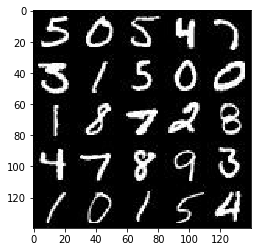

In [2]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
%matplotlib inline
import os
from glob import glob
from matplotlib import pyplot

mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'mnist/*.jpg'))[:show_n_images], 28, 28, 'L')
pyplot.imshow(helper.images_square_grid(mnist_images, 'L'), cmap='gray')

### CelebA
The [CelebFaces Attributes Dataset (CelebA)](http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html) dataset contains over 200,000 celebrity images with annotations.  Since you're going to be generating faces, you won't need the annotations.  You can view the first number of examples by changing `show_n_images`.

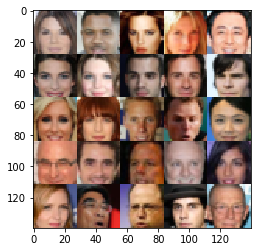

In [3]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'img_align_celeba/*.jpg'))[:show_n_images], 28, 28, 'RGB')
pyplot.imshow(helper.images_square_grid(mnist_images, 'RGB'))

## Preprocess the Data
Since the project's main focus is on building the GANs, we'll preprocess the data for you.  The values of the MNIST and CelebA dataset will be in the range of -0.5 to 0.5 of 28x28 dimensional images.  The CelebA images will be cropped to remove parts of the image that don't include a face, then resized down to 28x28.

The MNIST images are black and white images with a single [color channel](https://en.wikipedia.org/wiki/Channel_(digital_image%29) while the CelebA images have [3 color channels (RGB color channel)](https://en.wikipedia.org/wiki/Channel_(digital_image%29#RGB_Images).
## Build the Neural Network
You'll build the components necessary to build a GANs by implementing the following functions below:
- `model_inputs`
- `discriminator`
- `generator`
- `model_loss`
- `model_opt`
- `train`

### Check the Version of TensorFlow and Access to GPU
This will check to make sure you have the correct version of TensorFlow and access to a GPU

In [3]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
from distutils.version import LooseVersion
import warnings
import tensorflow as tf

# Check TensorFlow Version
assert LooseVersion(tf.__version__) >= LooseVersion('1.0'), 'Please use TensorFlow version 1.0 or newer.  You are using {}'.format(tf.__version__)
print('TensorFlow Version: {}'.format(tf.__version__))

# Check for a GPU
if not tf.test.gpu_device_name():
    warnings.warn('No GPU found. Please use a GPU to train your neural network.')
else:
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))

TensorFlow Version: 1.0.0


/Users/aclaudioquiros/anaconda3/lib/python3.6/site-packages/ipykernel/__main__.py:14: UserWarning: No GPU found. Please use a GPU to train your neural network.


### Input
Implement the `model_inputs` function to create TF Placeholders for the Neural Network. It should create the following placeholders:
- Real input images placeholder with rank 4 using `image_width`, `image_height`, and `image_channels`.
- Z input placeholder with rank 2 using `z_dim`.
- Learning rate placeholder with rank 0.

Return the placeholders in the following the tuple (tensor of real input images, tensor of z data)

In [4]:
import problem_unittests as tests

def model_inputs(image_width, image_height, image_channels, z_dim):
    """
    Create the model inputs
    :param image_width: The input image width
    :param image_height: The input image height
    :param image_channels: The number of image channels
    :param z_dim: The dimension of Z
    :return: Tuple of (tensor of real input images, tensor of z data, learning rate)
    """
    real_images_input = tf.placeholder(dtype=tf.float32, shape=(None, image_width, image_height, image_channels), name='real_images')

    # Keep Z dim in mind, might need to come back and fix it.
    z_input = tf.placeholder(dtype=tf.float32, shape=(None, z_dim), name='z_input')
    learning_rate = tf.placeholder(dtype=tf.float32, name='learning_rate')
    return real_images_input, z_input, learning_rate


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_inputs(model_inputs)

Tests Passed


### Discriminator
Implement `discriminator` to create a discriminator neural network that discriminates on `images`.  This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "discriminator" to allow the variables to be reused.  The function should return a tuple of (tensor output of the discriminator, tensor logits of the discriminator).

In [5]:
def leakyReLU(alpha, input_tensor):
    return tf.maximum(alpha*input_tensor, input_tensor)
    

def discriminator(images, reuse=False, alpha = 0.2):
    """
    Create the discriminator network
    :param images: Tensor of input image(s)
    :param reuse: Boolean if the weights should be reused
    :return: Tuple of (tensor output of the discriminator, tensor logits of the discriminator)
    """
    with tf.variable_scope('discriminator', reuse=reuse) as scope:
    
        c1 = tf.layers.conv2d(inputs=images, filters=64, kernel_size=(5,5), strides=(2,2), padding='same', \
                             initializer=tf.contrib.layers.xavier_initializer_conv2d())
        lr_c1 = leakyReLU(alpha, c1)
        
        c2 = tf.layers.conv2d(inputs=lr_c1, filters=128, kernel_size=(5,5), strides=(2,2), padding='same', \
                             initializer=tf.contrib.layers.xavier_initializer_conv2d())
        bc2 = tf.layers.batch_normalization(c2, training=True)
        lr_c2 = leakyReLU(alpha, bc2)
        
        c3 = tf.layers.conv2d(inputs=lr_c2, filters=256, kernel_size=(5,5), strides=(2,2), padding='same', \
                             initializer=tf.contrib.layers.xavier_initializer_conv2d())
        bc3 = tf.layers.batch_normalization(c3, training=True)
        lr_c3 = leakyReLU(alpha, bc3)
        
        c4 = tf.layers.conv2d(inputs=lr_c3, filters=512, kernel_size=(5,5), strides=(2,2), padding='same', \
                             initializer=tf.contrib.layers.xavier_initializer_conv2d())
        bc4 = tf.layers.batch_normalization(c4, training=True)
        lr_c4 = leakyReLU(alpha, bc4)
        
        # Flatten the channels.
        flatten = tf.contrib.layers.flatten(lr_c4)
        logits = tf.layers.dense(flatten, 1)
        output = tf.nn.sigmoid(logits)

#         print('Conv1 Shape', lr_c1.get_shape())
#         print('Conv2 Shape', lr_c2.get_shape())
#         print('Conv3 Shape', lr_c3.get_shape())
#         print('Conv4 Shape', lr_c4.get_shape())
#         print('Output', output.get_shape())
#         print('----------------------------------')
        
    return output, logits


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_discriminator(discriminator, tf)

Conv1 Shape (?, 14, 14, 64)
Conv2 Shape (?, 7, 7, 128)
Conv3 Shape (?, 4, 4, 256)
Conv4 Shape (?, 2, 2, 512)
Output (?, 1)
----------------------------------
Conv1 Shape (?, 14, 14, 64)
Conv2 Shape (?, 7, 7, 128)
Conv3 Shape (?, 4, 4, 256)
Conv4 Shape (?, 2, 2, 512)
Output (?, 1)
----------------------------------
Tests Passed


### Generator
Implement `generator` to generate an image using `z`. This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "generator" to allow the variables to be reused. The function should return the generated 28 x 28 x `out_channel_dim` images.

In [7]:
def generator(z, out_channel_dim, is_train=True, alpha = 0.2):
    """
    Create the generator network
    :param z: Input z
    :param out_channel_dim: The number of channels in the output image
    :param is_train: Boolean if generator is being used for training
    :return: The tensor output of the generator
    """
    # For training, create variables the first time.
    # When generating images, is_train=False, reuse variables.
    with tf.variable_scope('generator', reuse=not(is_train)):
    
        fc = tf.layers.dense(inputs=z, units=7*7*1024, activation=None)
        fc_reshape = tf.reshape(fc, (-1,7,7,1024))
        bfc = tf.layers.batch_normalization(fc_reshape)
        lr_fc = leakyReLU(alpha, bfc)
        
        c1 = tf.layers.conv2d_transpose(inputs=lr_fc, filters=512, kernel_size=(5,5), strides=(1,1), padding='same')
        bc1 = tf.layers.batch_normalization(c1, training=is_train)
        lr_cv1 = leakyReLU(alpha, bc1)
        
        c2 = tf.layers.conv2d_transpose(inputs=lr_cv1, filters=256, kernel_size=(5,5), strides=(2,2), padding='same')
        bc2 = tf.layers.batch_normalization(c2, training=is_train)
        lr_cv2 = leakyReLU(alpha, bc2)
        
        c3 = tf.layers.conv2d_transpose(inputs=lr_cv2, filters=128, kernel_size=(5,5), strides=(1,1), padding='same')
        bc3 = tf.layers.batch_normalization(c3, training=is_train)
        lr_cv3 = leakyReLU(alpha, bc3)
        
        c4 = tf.layers.conv2d_transpose(inputs=lr_cv3, filters=64, kernel_size=(5,5), strides=(2,2), padding='same')
        bc4 = tf.layers.batch_normalization(c4, training=is_train)
        lr_cv4 = leakyReLU(alpha, bc4)

        logits = tf.layers.conv2d_transpose(inputs=lr_cv4, filters=out_channel_dim, kernel_size=(5,5), strides=(1,1), padding='same')
        output = tf.nn.tanh(logits)

#         print('FC Shape', lr_fc.get_shape())
#         print('Conv1 Shape', lr_cv1.get_shape())
#         print('Conv2 Shape', lr_cv2.get_shape())
#         print('Conv3 Shape', lr_cv3.get_shape())
#         print('Conv4 Shape', lr_cv4.get_shape())
#         print('Output', output.get_shape())
#         print('----------------------------------')
        
    return output


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_generator(generator, tf)

Tests Passed


### Loss
Implement `model_loss` to build the GANs for training and calculate the loss.  The function should return a tuple of (discriminator loss, generator loss).  Use the following functions you implemented:
- `discriminator(images, reuse=False)`
- `generator(z, out_channel_dim, is_train=True)`

In [8]:
def model_loss(input_real, input_z, out_channel_dim):
    """
    Get the loss for the discriminator and generator
    :param input_real: Images from the real dataset
    :param input_z: Z input
    :param out_channel_dim: The number of channels in the output image
    :return: A tuple of (discriminator loss, generator loss)
    """
    
    output_fake_image = generator(input_z, out_channel_dim, is_train=True)
    
    output_real, logits_real = discriminator(input_real, reuse=False)
    output_fake, logits_fake = discriminator(output_fake_image, reuse=True)
    
    loss_dis_real = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=logits_real, labels=tf.ones_like(logits_real)*0.9))
    loss_dis_fake = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=logits_fake, labels=tf.zeros_like(logits_real)))
    loss_dis = loss_dis_fake + loss_dis_real
    
    loss_gen = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(labels=tf.ones_like(logits_real), logits=logits_fake))
    
    return loss_dis, loss_gen


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_loss(model_loss)

Tests Passed


### Optimization
Implement `model_opt` to create the optimization operations for the GANs. Use [`tf.trainable_variables`](https://www.tensorflow.org/api_docs/python/tf/trainable_variables) to get all the trainable variables.  Filter the variables with names that are in the discriminator and generator scope names.  The function should return a tuple of (discriminator training operation, generator training operation).

In [9]:
def model_opt(d_loss, g_loss, learning_rate, beta1):
    """
    Get optimization operations
    :param d_loss: Discriminator loss Tensor
    :param g_loss: Generator loss Tensor
    :param learning_rate: Learning Rate Placeholder
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :return: A tuple of (discriminator training operation, generator training operation)
    """
    trainable_variables = tf.trainable_variables()
    generator_variables = [variable for variable in trainable_variables if variable.name.startswith('generator')]    
    discriminator_variables = [variable for variable in trainable_variables if variable.name.startswith('discriminator')]
    
    # Handle batch normalization variables.
    with tf.control_dependencies(tf.get_collection(tf.GraphKeys.UPDATE_OPS)):
        train_generator = tf.train.AdamOptimizer(learning_rate=learning_rate, beta1=beta1).minimize(g_loss, var_list=generator_variables)
        train_discriminator = tf.train.AdamOptimizer(learning_rate=learning_rate, beta1=beta1).minimize(d_loss, var_list=discriminator_variables)
    return train_discriminator, train_generator


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_opt(model_opt, tf)

Tests Passed


## Neural Network Training
### Show Output
Use this function to show the current output of the generator during training. It will help you determine how well the GANs is training.

In [10]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import numpy as np

def show_generator_output(sess, n_images, input_z, out_channel_dim, image_mode):
    """
    Show example output for the generator
    :param sess: TensorFlow session
    :param n_images: Number of Images to display
    :param input_z: Input Z Tensor
    :param out_channel_dim: The number of channels in the output image
    :param image_mode: The mode to use for images ("RGB" or "L")
    """
    cmap = None if image_mode == 'RGB' else 'gray'
    z_dim = input_z.get_shape().as_list()[-1]
    example_z = np.random.uniform(-1, 1, size=[n_images, z_dim])

    samples = sess.run(
        generator(input_z, out_channel_dim, False),
        feed_dict={input_z: example_z})

    images_grid = helper.images_square_grid(samples, image_mode)
    pyplot.imshow(images_grid, cmap=cmap)
    pyplot.show()

### Train
Implement `train` to build and train the GANs.  Use the following functions you implemented:
- `model_inputs(image_width, image_height, image_channels, z_dim)`
- `model_loss(input_real, input_z, out_channel_dim)`
- `model_opt(d_loss, g_loss, learning_rate, beta1)`

Use the `show_generator_output` to show `generator` output while you train. Running `show_generator_output` for every batch will drastically increase training time and increase the size of the notebook.  It's recommended to print the `generator` output every 100 batches.

In [11]:
def train(epoch_count, batch_size, z_dim, learning_rate, beta1, get_batches, data_shape, data_image_mode):
    """
    Train the GAN
    :param epoch_count: Number of epochs
    :param batch_size: Batch Size
    :param z_dim: Z dimension
    :param learning_rate: Learning Rate
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :param get_batches: Function to get batches
    :param data_shape: Shape of the data
    :param data_image_mode: The image mode to use for images ("RGB" or "L")
    """

    data_size, image_width, image_height, image_channels = data_shape
    real_images_input, z_input, learning_rate_input = model_inputs(image_width, image_height, image_channels, z_dim)
    loss_dis, loss_gen = model_loss(real_images_input, z_input, image_channels)
    train_discriminator, train_generator = model_opt(loss_dis, loss_gen, learning_rate, beta1)
    
    samples = []
    losses = []
    run_epochs = 0

    show_e = 100
    print_e = 10
    n_images = 25
    
    with tf.Session() as sess:
        # Initialize variables.
        sess.run(tf.global_variables_initializer())
        for epoch_i in range(epoch_count+1):
            for batch_images in get_batches(batch_size):
                
                batch_images = batch_images * 2
                z_batch = np.random.uniform(low=-1,high=1, size=(batch_size, z_dim))
                
                # Run gradient descent.
                _ = sess.run(train_discriminator, 
                             feed_dict={z_input:z_batch, real_images_input:batch_images, \
                                        learning_rate_input: learning_rate})
                _ = sess.run(train_generator, 
                             feed_dict={z_input:z_batch, real_images_input:batch_images, learning_rate_input: learning_rate})
                
                # Show losses every 'print_e' iterations.
                if (run_epochs%print_e==0):
                    epoch_loss_dis = sess.run(loss_dis, feed_dict={z_input:z_batch, real_images_input:batch_images})
                    epoch_loss_gen = sess.run(loss_gen, feed_dict={z_input:z_batch, real_images_input:batch_images})
                    losses.append((epoch_loss_dis, epoch_loss_gen))
                    print('Epochs: %s/%s. Discriminator Loss: %s Generator Loss: %s' % (epoch_i, epoch_count,
                                                                                        np.round(epoch_loss_dis,3), 
                                                                                        np.round(epoch_loss_gen,3)))
                # Show generated images every 'show_e' iterations.
                if (run_epochs%show_e==0):
                    show_generator_output(sess, n_images, z_input, image_channels, data_image_mode)
                run_epochs+=1
                
                

### MNIST
Test your GANs architecture on MNIST.  After 2 epochs, the GANs should be able to generate images that look like handwritten digits.  Make sure the loss of the generator is lower than the loss of the discriminator or close to 0.

Epochs: 0/2. Discriminator Loss: 9.813 Generator Loss: 0.0


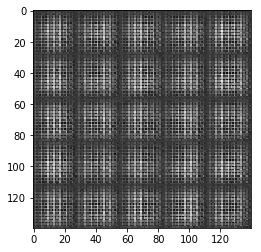

Epochs: 0/2. Discriminator Loss: 0.398 Generator Loss: 4.982
Epochs: 0/2. Discriminator Loss: 0.4 Generator Loss: 3.922
Epochs: 0/2. Discriminator Loss: 0.721 Generator Loss: 1.569
Epochs: 0/2. Discriminator Loss: 0.387 Generator Loss: 5.373
Epochs: 0/2. Discriminator Loss: 1.179 Generator Loss: 0.718
Epochs: 0/2. Discriminator Loss: 0.966 Generator Loss: 1.03
Epochs: 0/2. Discriminator Loss: 1.554 Generator Loss: 0.457
Epochs: 0/2. Discriminator Loss: 1.421 Generator Loss: 0.747
Epochs: 0/2. Discriminator Loss: 1.239 Generator Loss: 0.656
Epochs: 0/2. Discriminator Loss: 0.946 Generator Loss: 1.787


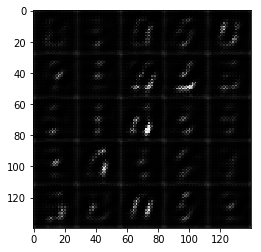

Epochs: 0/2. Discriminator Loss: 1.269 Generator Loss: 0.882
Epochs: 0/2. Discriminator Loss: 0.756 Generator Loss: 1.479
Epochs: 0/2. Discriminator Loss: 1.189 Generator Loss: 2.19
Epochs: 0/2. Discriminator Loss: 1.154 Generator Loss: 1.042
Epochs: 0/2. Discriminator Loss: 0.957 Generator Loss: 1.06
Epochs: 0/2. Discriminator Loss: 1.089 Generator Loss: 1.272
Epochs: 0/2. Discriminator Loss: 1.245 Generator Loss: 0.659
Epochs: 0/2. Discriminator Loss: 1.939 Generator Loss: 0.277
Epochs: 0/2. Discriminator Loss: 1.401 Generator Loss: 0.583
Epochs: 0/2. Discriminator Loss: 1.202 Generator Loss: 0.717


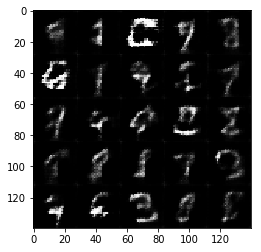

Epochs: 0/2. Discriminator Loss: 1.213 Generator Loss: 1.065
Epochs: 0/2. Discriminator Loss: 1.161 Generator Loss: 0.989
Epochs: 0/2. Discriminator Loss: 1.239 Generator Loss: 0.872
Epochs: 0/2. Discriminator Loss: 1.219 Generator Loss: 0.869
Epochs: 0/2. Discriminator Loss: 1.211 Generator Loss: 0.879
Epochs: 0/2. Discriminator Loss: 1.485 Generator Loss: 1.838
Epochs: 0/2. Discriminator Loss: 1.128 Generator Loss: 1.215
Epochs: 0/2. Discriminator Loss: 1.163 Generator Loss: 0.975
Epochs: 0/2. Discriminator Loss: 1.463 Generator Loss: 0.525
Epochs: 0/2. Discriminator Loss: 1.368 Generator Loss: 0.552


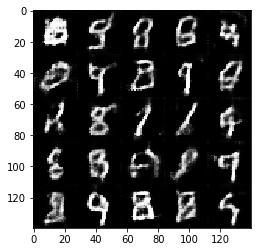

Epochs: 0/2. Discriminator Loss: 1.332 Generator Loss: 0.647
Epochs: 0/2. Discriminator Loss: 1.257 Generator Loss: 0.799
Epochs: 0/2. Discriminator Loss: 1.278 Generator Loss: 0.695
Epochs: 0/2. Discriminator Loss: 1.266 Generator Loss: 0.708
Epochs: 0/2. Discriminator Loss: 1.251 Generator Loss: 0.679
Epochs: 0/2. Discriminator Loss: 1.23 Generator Loss: 0.824
Epochs: 0/2. Discriminator Loss: 1.334 Generator Loss: 0.696
Epochs: 0/2. Discriminator Loss: 1.278 Generator Loss: 0.916
Epochs: 0/2. Discriminator Loss: 1.161 Generator Loss: 0.804
Epochs: 0/2. Discriminator Loss: 1.355 Generator Loss: 0.598


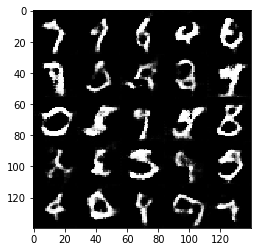

Epochs: 0/2. Discriminator Loss: 1.144 Generator Loss: 0.972
Epochs: 0/2. Discriminator Loss: 1.271 Generator Loss: 0.972
Epochs: 0/2. Discriminator Loss: 1.098 Generator Loss: 0.912
Epochs: 0/2. Discriminator Loss: 1.24 Generator Loss: 0.798
Epochs: 0/2. Discriminator Loss: 1.197 Generator Loss: 0.843
Epochs: 0/2. Discriminator Loss: 1.216 Generator Loss: 0.752
Epochs: 0/2. Discriminator Loss: 1.214 Generator Loss: 0.943
Epochs: 0/2. Discriminator Loss: 1.167 Generator Loss: 1.172
Epochs: 0/2. Discriminator Loss: 1.184 Generator Loss: 0.81
Epochs: 0/2. Discriminator Loss: 1.378 Generator Loss: 1.15


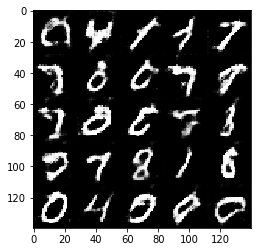

Epochs: 0/2. Discriminator Loss: 1.226 Generator Loss: 0.75
Epochs: 0/2. Discriminator Loss: 1.34 Generator Loss: 0.682
Epochs: 0/2. Discriminator Loss: 1.233 Generator Loss: 0.81
Epochs: 0/2. Discriminator Loss: 1.188 Generator Loss: 1.186
Epochs: 0/2. Discriminator Loss: 1.172 Generator Loss: 1.008
Epochs: 0/2. Discriminator Loss: 1.29 Generator Loss: 1.448
Epochs: 0/2. Discriminator Loss: 1.308 Generator Loss: 0.64
Epochs: 0/2. Discriminator Loss: 1.361 Generator Loss: 0.576
Epochs: 0/2. Discriminator Loss: 1.31 Generator Loss: 0.897
Epochs: 0/2. Discriminator Loss: 1.32 Generator Loss: 0.846


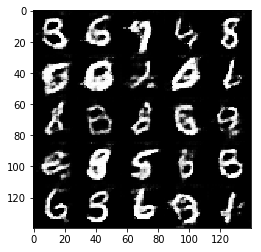

Epochs: 0/2. Discriminator Loss: 1.342 Generator Loss: 0.545
Epochs: 0/2. Discriminator Loss: 1.164 Generator Loss: 1.025
Epochs: 0/2. Discriminator Loss: 1.331 Generator Loss: 0.936
Epochs: 0/2. Discriminator Loss: 1.481 Generator Loss: 0.559
Epochs: 0/2. Discriminator Loss: 1.2 Generator Loss: 0.764
Epochs: 0/2. Discriminator Loss: 1.359 Generator Loss: 0.579
Epochs: 0/2. Discriminator Loss: 1.193 Generator Loss: 0.697
Epochs: 0/2. Discriminator Loss: 1.515 Generator Loss: 0.52
Epochs: 0/2. Discriminator Loss: 1.243 Generator Loss: 0.667
Epochs: 0/2. Discriminator Loss: 1.308 Generator Loss: 0.783


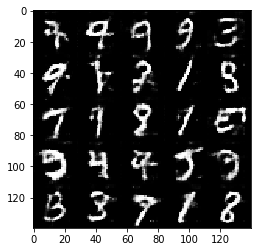

Epochs: 0/2. Discriminator Loss: 1.164 Generator Loss: 0.742
Epochs: 0/2. Discriminator Loss: 1.35 Generator Loss: 0.603
Epochs: 0/2. Discriminator Loss: 1.194 Generator Loss: 1.303
Epochs: 0/2. Discriminator Loss: 1.181 Generator Loss: 1.102
Epochs: 0/2. Discriminator Loss: 1.239 Generator Loss: 0.796
Epochs: 0/2. Discriminator Loss: 1.257 Generator Loss: 1.19
Epochs: 0/2. Discriminator Loss: 1.326 Generator Loss: 0.718
Epochs: 0/2. Discriminator Loss: 1.354 Generator Loss: 0.6
Epochs: 0/2. Discriminator Loss: 1.316 Generator Loss: 0.717
Epochs: 0/2. Discriminator Loss: 1.126 Generator Loss: 0.977


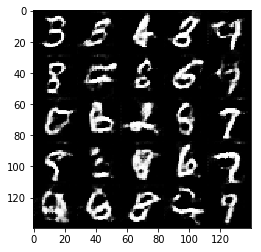

Epochs: 0/2. Discriminator Loss: 1.116 Generator Loss: 0.813
Epochs: 0/2. Discriminator Loss: 1.1 Generator Loss: 0.979
Epochs: 0/2. Discriminator Loss: 1.177 Generator Loss: 0.834
Epochs: 0/2. Discriminator Loss: 1.194 Generator Loss: 0.825
Epochs: 0/2. Discriminator Loss: 1.383 Generator Loss: 0.591
Epochs: 0/2. Discriminator Loss: 1.232 Generator Loss: 0.722
Epochs: 0/2. Discriminator Loss: 1.329 Generator Loss: 0.688
Epochs: 0/2. Discriminator Loss: 1.256 Generator Loss: 0.66
Epochs: 0/2. Discriminator Loss: 1.169 Generator Loss: 0.844
Epochs: 0/2. Discriminator Loss: 1.119 Generator Loss: 0.887


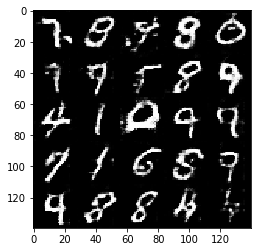

Epochs: 0/2. Discriminator Loss: 1.157 Generator Loss: 1.163
Epochs: 0/2. Discriminator Loss: 1.175 Generator Loss: 0.794
Epochs: 0/2. Discriminator Loss: 1.256 Generator Loss: 0.731
Epochs: 1/2. Discriminator Loss: 1.346 Generator Loss: 1.298
Epochs: 1/2. Discriminator Loss: 1.248 Generator Loss: 0.759
Epochs: 1/2. Discriminator Loss: 1.087 Generator Loss: 1.353
Epochs: 1/2. Discriminator Loss: 1.191 Generator Loss: 0.82
Epochs: 1/2. Discriminator Loss: 1.117 Generator Loss: 0.786
Epochs: 1/2. Discriminator Loss: 1.154 Generator Loss: 0.851
Epochs: 1/2. Discriminator Loss: 1.495 Generator Loss: 1.675


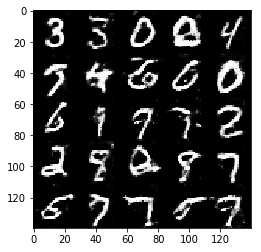

Epochs: 1/2. Discriminator Loss: 1.17 Generator Loss: 0.886
Epochs: 1/2. Discriminator Loss: 1.292 Generator Loss: 0.738
Epochs: 1/2. Discriminator Loss: 1.262 Generator Loss: 0.891
Epochs: 1/2. Discriminator Loss: 1.186 Generator Loss: 0.875
Epochs: 1/2. Discriminator Loss: 1.371 Generator Loss: 0.657
Epochs: 1/2. Discriminator Loss: 1.335 Generator Loss: 0.616
Epochs: 1/2. Discriminator Loss: 1.301 Generator Loss: 0.715
Epochs: 1/2. Discriminator Loss: 1.37 Generator Loss: 1.102
Epochs: 1/2. Discriminator Loss: 1.134 Generator Loss: 0.965
Epochs: 1/2. Discriminator Loss: 0.991 Generator Loss: 1.077


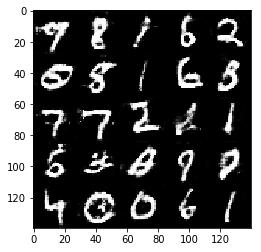

Epochs: 1/2. Discriminator Loss: 1.211 Generator Loss: 0.944
Epochs: 1/2. Discriminator Loss: 1.425 Generator Loss: 0.521
Epochs: 1/2. Discriminator Loss: 1.151 Generator Loss: 0.826
Epochs: 1/2. Discriminator Loss: 1.282 Generator Loss: 0.692
Epochs: 1/2. Discriminator Loss: 1.284 Generator Loss: 0.93
Epochs: 1/2. Discriminator Loss: 1.277 Generator Loss: 1.094
Epochs: 1/2. Discriminator Loss: 1.232 Generator Loss: 0.733
Epochs: 1/2. Discriminator Loss: 1.479 Generator Loss: 0.479
Epochs: 1/2. Discriminator Loss: 1.202 Generator Loss: 0.798
Epochs: 1/2. Discriminator Loss: 1.409 Generator Loss: 0.507


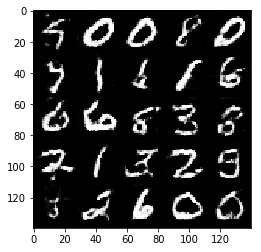

Epochs: 1/2. Discriminator Loss: 1.017 Generator Loss: 0.942
Epochs: 1/2. Discriminator Loss: 1.095 Generator Loss: 1.19
Epochs: 1/2. Discriminator Loss: 1.346 Generator Loss: 0.559
Epochs: 1/2. Discriminator Loss: 1.605 Generator Loss: 1.512
Epochs: 1/2. Discriminator Loss: 1.158 Generator Loss: 0.855
Epochs: 1/2. Discriminator Loss: 1.034 Generator Loss: 1.049
Epochs: 1/2. Discriminator Loss: 1.178 Generator Loss: 1.032
Epochs: 1/2. Discriminator Loss: 1.263 Generator Loss: 0.694
Epochs: 1/2. Discriminator Loss: 1.427 Generator Loss: 0.5
Epochs: 1/2. Discriminator Loss: 1.222 Generator Loss: 0.765


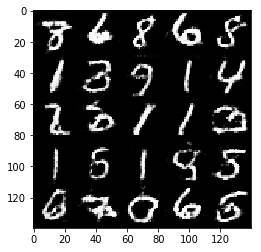

Epochs: 1/2. Discriminator Loss: 1.18 Generator Loss: 0.709
Epochs: 1/2. Discriminator Loss: 1.374 Generator Loss: 0.519
Epochs: 1/2. Discriminator Loss: 1.448 Generator Loss: 0.484
Epochs: 1/2. Discriminator Loss: 1.201 Generator Loss: 0.672
Epochs: 1/2. Discriminator Loss: 1.528 Generator Loss: 0.432
Epochs: 1/2. Discriminator Loss: 0.988 Generator Loss: 1.154
Epochs: 1/2. Discriminator Loss: 1.395 Generator Loss: 0.577
Epochs: 1/2. Discriminator Loss: 0.96 Generator Loss: 1.019
Epochs: 1/2. Discriminator Loss: 1.021 Generator Loss: 1.03
Epochs: 1/2. Discriminator Loss: 1.437 Generator Loss: 0.513


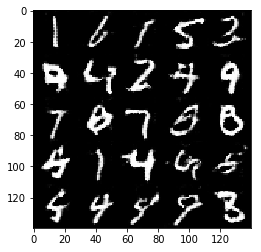

Epochs: 1/2. Discriminator Loss: 1.192 Generator Loss: 1.26
Epochs: 1/2. Discriminator Loss: 1.234 Generator Loss: 0.688
Epochs: 1/2. Discriminator Loss: 1.17 Generator Loss: 0.726
Epochs: 1/2. Discriminator Loss: 1.072 Generator Loss: 0.958
Epochs: 1/2. Discriminator Loss: 1.136 Generator Loss: 0.75
Epochs: 1/2. Discriminator Loss: 1.198 Generator Loss: 0.835
Epochs: 1/2. Discriminator Loss: 1.701 Generator Loss: 0.341
Epochs: 1/2. Discriminator Loss: 1.242 Generator Loss: 0.588
Epochs: 1/2. Discriminator Loss: 1.412 Generator Loss: 0.481
Epochs: 1/2. Discriminator Loss: 1.484 Generator Loss: 0.449


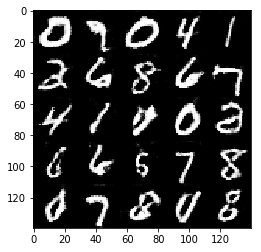

Epochs: 1/2. Discriminator Loss: 1.621 Generator Loss: 0.367
Epochs: 1/2. Discriminator Loss: 1.136 Generator Loss: 0.73
Epochs: 1/2. Discriminator Loss: 1.205 Generator Loss: 0.737
Epochs: 1/2. Discriminator Loss: 1.595 Generator Loss: 0.424
Epochs: 1/2. Discriminator Loss: 1.47 Generator Loss: 0.45
Epochs: 1/2. Discriminator Loss: 1.093 Generator Loss: 0.937
Epochs: 1/2. Discriminator Loss: 1.134 Generator Loss: 1.045
Epochs: 1/2. Discriminator Loss: 1.525 Generator Loss: 0.465
Epochs: 1/2. Discriminator Loss: 1.389 Generator Loss: 0.586
Epochs: 1/2. Discriminator Loss: 1.247 Generator Loss: 0.724


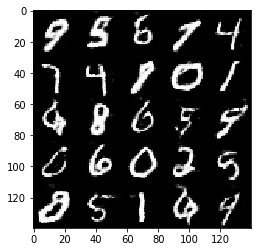

Epochs: 1/2. Discriminator Loss: 1.291 Generator Loss: 0.694
Epochs: 1/2. Discriminator Loss: 0.95 Generator Loss: 1.068
Epochs: 1/2. Discriminator Loss: 1.189 Generator Loss: 0.749
Epochs: 1/2. Discriminator Loss: 1.257 Generator Loss: 0.676
Epochs: 1/2. Discriminator Loss: 1.601 Generator Loss: 0.389
Epochs: 1/2. Discriminator Loss: 1.05 Generator Loss: 0.92
Epochs: 1/2. Discriminator Loss: 1.237 Generator Loss: 0.593
Epochs: 1/2. Discriminator Loss: 1.51 Generator Loss: 0.465
Epochs: 1/2. Discriminator Loss: 1.114 Generator Loss: 0.822
Epochs: 1/2. Discriminator Loss: 1.313 Generator Loss: 0.586


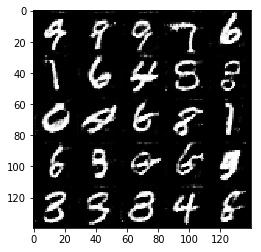

Epochs: 1/2. Discriminator Loss: 1.025 Generator Loss: 1.099
Epochs: 1/2. Discriminator Loss: 1.487 Generator Loss: 0.456
Epochs: 1/2. Discriminator Loss: 1.423 Generator Loss: 0.484
Epochs: 1/2. Discriminator Loss: 1.38 Generator Loss: 0.575
Epochs: 1/2. Discriminator Loss: 1.496 Generator Loss: 0.429
Epochs: 1/2. Discriminator Loss: 1.224 Generator Loss: 0.63
Epochs: 1/2. Discriminator Loss: 1.031 Generator Loss: 0.892
Epochs: 1/2. Discriminator Loss: 1.226 Generator Loss: 1.252
Epochs: 1/2. Discriminator Loss: 0.966 Generator Loss: 1.238
Epochs: 1/2. Discriminator Loss: 1.24 Generator Loss: 0.645


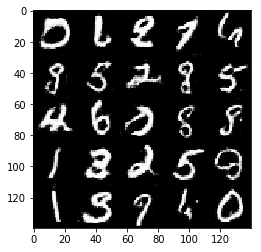

Epochs: 1/2. Discriminator Loss: 1.038 Generator Loss: 0.841
Epochs: 1/2. Discriminator Loss: 1.055 Generator Loss: 0.821
Epochs: 1/2. Discriminator Loss: 1.116 Generator Loss: 0.702
Epochs: 1/2. Discriminator Loss: 1.193 Generator Loss: 0.662
Epochs: 1/2. Discriminator Loss: 1.212 Generator Loss: 0.885
Epochs: 1/2. Discriminator Loss: 1.068 Generator Loss: 0.783
Epochs: 1/2. Discriminator Loss: 1.364 Generator Loss: 0.526
Epochs: 2/2. Discriminator Loss: 1.536 Generator Loss: 0.436
Epochs: 2/2. Discriminator Loss: 1.044 Generator Loss: 0.956
Epochs: 2/2. Discriminator Loss: 1.049 Generator Loss: 1.365


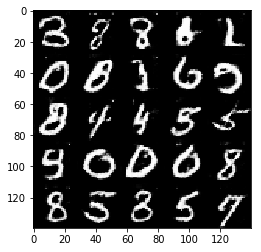

Epochs: 2/2. Discriminator Loss: 1.396 Generator Loss: 0.504
Epochs: 2/2. Discriminator Loss: 1.066 Generator Loss: 1.106
Epochs: 2/2. Discriminator Loss: 1.244 Generator Loss: 1.268
Epochs: 2/2. Discriminator Loss: 1.208 Generator Loss: 1.171
Epochs: 2/2. Discriminator Loss: 1.164 Generator Loss: 0.636
Epochs: 2/2. Discriminator Loss: 1.152 Generator Loss: 1.018
Epochs: 2/2. Discriminator Loss: 1.098 Generator Loss: 0.859
Epochs: 2/2. Discriminator Loss: 1.347 Generator Loss: 0.525
Epochs: 2/2. Discriminator Loss: 0.982 Generator Loss: 0.892
Epochs: 2/2. Discriminator Loss: 1.019 Generator Loss: 0.841


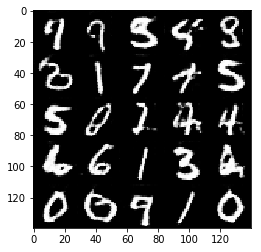

Epochs: 2/2. Discriminator Loss: 1.006 Generator Loss: 0.943
Epochs: 2/2. Discriminator Loss: 1.067 Generator Loss: 0.729
Epochs: 2/2. Discriminator Loss: 1.012 Generator Loss: 0.836
Epochs: 2/2. Discriminator Loss: 1.901 Generator Loss: 0.325
Epochs: 2/2. Discriminator Loss: 1.171 Generator Loss: 0.796
Epochs: 2/2. Discriminator Loss: 1.172 Generator Loss: 0.656
Epochs: 2/2. Discriminator Loss: 1.25 Generator Loss: 0.618
Epochs: 2/2. Discriminator Loss: 1.344 Generator Loss: 0.52
Epochs: 2/2. Discriminator Loss: 1.087 Generator Loss: 0.789
Epochs: 2/2. Discriminator Loss: 1.176 Generator Loss: 0.688


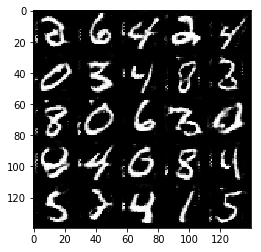

Epochs: 2/2. Discriminator Loss: 1.351 Generator Loss: 0.551
Epochs: 2/2. Discriminator Loss: 0.953 Generator Loss: 1.307
Epochs: 2/2. Discriminator Loss: 0.952 Generator Loss: 0.974
Epochs: 2/2. Discriminator Loss: 0.897 Generator Loss: 1.153
Epochs: 2/2. Discriminator Loss: 1.068 Generator Loss: 0.98
Epochs: 2/2. Discriminator Loss: 0.956 Generator Loss: 0.845
Epochs: 2/2. Discriminator Loss: 1.0 Generator Loss: 1.803
Epochs: 2/2. Discriminator Loss: 1.28 Generator Loss: 0.617
Epochs: 2/2. Discriminator Loss: 1.134 Generator Loss: 0.913
Epochs: 2/2. Discriminator Loss: 0.869 Generator Loss: 1.415


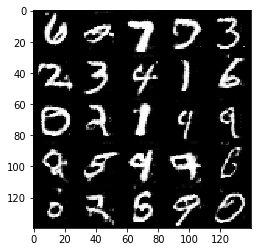

Epochs: 2/2. Discriminator Loss: 1.126 Generator Loss: 0.843
Epochs: 2/2. Discriminator Loss: 1.457 Generator Loss: 0.472
Epochs: 2/2. Discriminator Loss: 1.734 Generator Loss: 0.419
Epochs: 2/2. Discriminator Loss: 1.188 Generator Loss: 1.021
Epochs: 2/2. Discriminator Loss: 1.284 Generator Loss: 0.681
Epochs: 2/2. Discriminator Loss: 0.793 Generator Loss: 1.814
Epochs: 2/2. Discriminator Loss: 0.999 Generator Loss: 1.001
Epochs: 2/2. Discriminator Loss: 1.829 Generator Loss: 0.31
Epochs: 2/2. Discriminator Loss: 1.098 Generator Loss: 0.994
Epochs: 2/2. Discriminator Loss: 0.989 Generator Loss: 1.132


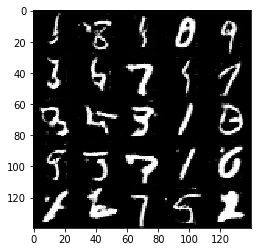

Epochs: 2/2. Discriminator Loss: 1.415 Generator Loss: 0.464
Epochs: 2/2. Discriminator Loss: 1.234 Generator Loss: 2.117
Epochs: 2/2. Discriminator Loss: 0.874 Generator Loss: 1.075
Epochs: 2/2. Discriminator Loss: 1.161 Generator Loss: 0.686
Epochs: 2/2. Discriminator Loss: 1.323 Generator Loss: 0.529
Epochs: 2/2. Discriminator Loss: 0.744 Generator Loss: 1.235
Epochs: 2/2. Discriminator Loss: 1.036 Generator Loss: 0.784
Epochs: 2/2. Discriminator Loss: 0.981 Generator Loss: 1.328
Epochs: 2/2. Discriminator Loss: 0.925 Generator Loss: 1.168
Epochs: 2/2. Discriminator Loss: 1.117 Generator Loss: 0.747


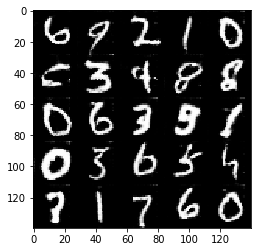

Epochs: 2/2. Discriminator Loss: 1.302 Generator Loss: 0.576
Epochs: 2/2. Discriminator Loss: 1.128 Generator Loss: 1.171
Epochs: 2/2. Discriminator Loss: 1.286 Generator Loss: 0.568
Epochs: 2/2. Discriminator Loss: 1.116 Generator Loss: 0.751
Epochs: 2/2. Discriminator Loss: 1.082 Generator Loss: 0.75
Epochs: 2/2. Discriminator Loss: 1.219 Generator Loss: 0.705
Epochs: 2/2. Discriminator Loss: 1.645 Generator Loss: 0.354
Epochs: 2/2. Discriminator Loss: 1.0 Generator Loss: 1.047
Epochs: 2/2. Discriminator Loss: 0.986 Generator Loss: 1.93
Epochs: 2/2. Discriminator Loss: 1.085 Generator Loss: 1.09


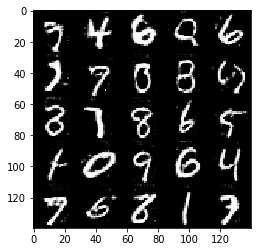

Epochs: 2/2. Discriminator Loss: 0.852 Generator Loss: 1.249
Epochs: 2/2. Discriminator Loss: 1.517 Generator Loss: 2.188
Epochs: 2/2. Discriminator Loss: 1.143 Generator Loss: 0.718
Epochs: 2/2. Discriminator Loss: 0.868 Generator Loss: 1.434
Epochs: 2/2. Discriminator Loss: 1.115 Generator Loss: 1.405
Epochs: 2/2. Discriminator Loss: 1.008 Generator Loss: 0.903
Epochs: 2/2. Discriminator Loss: 1.346 Generator Loss: 0.516
Epochs: 2/2. Discriminator Loss: 1.072 Generator Loss: 2.538
Epochs: 2/2. Discriminator Loss: 1.27 Generator Loss: 0.584
Epochs: 2/2. Discriminator Loss: 1.017 Generator Loss: 1.281


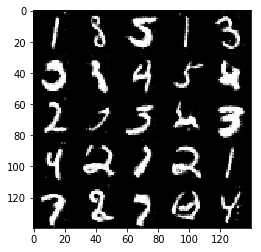

Epochs: 2/2. Discriminator Loss: 1.395 Generator Loss: 0.517
Epochs: 2/2. Discriminator Loss: 0.997 Generator Loss: 0.877
Epochs: 2/2. Discriminator Loss: 1.13 Generator Loss: 0.713
Epochs: 2/2. Discriminator Loss: 0.81 Generator Loss: 1.694
Epochs: 2/2. Discriminator Loss: 0.874 Generator Loss: 0.979
Epochs: 2/2. Discriminator Loss: 0.994 Generator Loss: 0.897
Epochs: 2/2. Discriminator Loss: 1.143 Generator Loss: 0.801
Epochs: 2/2. Discriminator Loss: 0.937 Generator Loss: 1.144
Epochs: 2/2. Discriminator Loss: 0.9 Generator Loss: 1.183
Epochs: 2/2. Discriminator Loss: 1.229 Generator Loss: 0.591


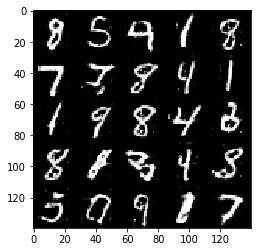

Epochs: 2/2. Discriminator Loss: 0.792 Generator Loss: 1.295
Epochs: 2/2. Discriminator Loss: 0.658 Generator Loss: 1.943
Epochs: 2/2. Discriminator Loss: 1.022 Generator Loss: 1.874
Epochs: 2/2. Discriminator Loss: 0.901 Generator Loss: 1.329
Epochs: 2/2. Discriminator Loss: 1.195 Generator Loss: 0.683
Epochs: 2/2. Discriminator Loss: 0.975 Generator Loss: 0.976
Epochs: 2/2. Discriminator Loss: 1.373 Generator Loss: 0.537
Epochs: 2/2. Discriminator Loss: 0.725 Generator Loss: 1.539
Epochs: 2/2. Discriminator Loss: 0.805 Generator Loss: 1.179
Epochs: 2/2. Discriminator Loss: 1.207 Generator Loss: 0.617


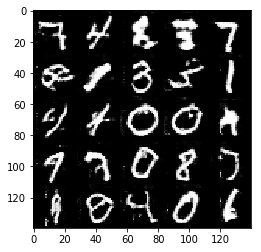

Epochs: 2/2. Discriminator Loss: 0.814 Generator Loss: 1.309


In [12]:
batch_size = 32
z_dim = 100
learning_rate = 0.0005
beta1 = 0.5


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 2

mnist_dataset = helper.Dataset('mnist', glob(os.path.join(data_dir, 'mnist/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, mnist_dataset.get_batches,
          mnist_dataset.shape, mnist_dataset.image_mode)

### Submitting This Project
When submitting this project, make sure to run all the cells before saving the notebook. Save the notebook file as "dlnd_face_generation.ipynb" and save it as a HTML file under "File" -> "Download as". Include the "helper.py" and "problem_unittests.py" files in your submission.

### CelebA
Run your GANs on CelebA.  It will take around 20 minutes on the average GPU to run one epoch.  You can run the whole epoch or stop when it starts to generate realistic faces.

Epochs: 0/1. Discriminator Loss: 11.485 Generator Loss: 0.0


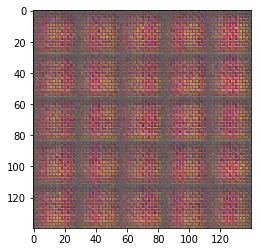

Epochs: 0/1. Discriminator Loss: 1.304 Generator Loss: 0.647
Epochs: 0/1. Discriminator Loss: 0.384 Generator Loss: 9.029
Epochs: 0/1. Discriminator Loss: 0.963 Generator Loss: 0.92
Epochs: 0/1. Discriminator Loss: 1.69 Generator Loss: 6.715
Epochs: 0/1. Discriminator Loss: 1.161 Generator Loss: 2.083
Epochs: 0/1. Discriminator Loss: 0.664 Generator Loss: 2.125
Epochs: 0/1. Discriminator Loss: 1.214 Generator Loss: 0.645
Epochs: 0/1. Discriminator Loss: 0.9 Generator Loss: 3.309
Epochs: 0/1. Discriminator Loss: 1.653 Generator Loss: 3.916
Epochs: 0/1. Discriminator Loss: 1.243 Generator Loss: 4.892


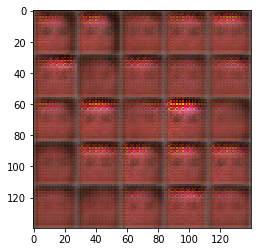

Epochs: 0/1. Discriminator Loss: 1.839 Generator Loss: 0.331
Epochs: 0/1. Discriminator Loss: 1.045 Generator Loss: 1.08
Epochs: 0/1. Discriminator Loss: 1.676 Generator Loss: 0.431
Epochs: 0/1. Discriminator Loss: 1.719 Generator Loss: 0.551
Epochs: 0/1. Discriminator Loss: 1.256 Generator Loss: 1.28
Epochs: 0/1. Discriminator Loss: 1.283 Generator Loss: 0.863
Epochs: 0/1. Discriminator Loss: 1.007 Generator Loss: 1.439
Epochs: 0/1. Discriminator Loss: 1.199 Generator Loss: 1.251
Epochs: 0/1. Discriminator Loss: 1.212 Generator Loss: 1.401
Epochs: 0/1. Discriminator Loss: 1.235 Generator Loss: 0.857


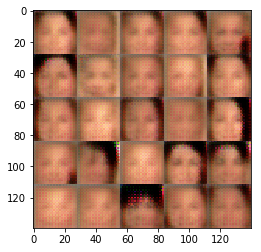

Epochs: 0/1. Discriminator Loss: 1.118 Generator Loss: 1.525
Epochs: 0/1. Discriminator Loss: 1.174 Generator Loss: 0.754
Epochs: 0/1. Discriminator Loss: 0.71 Generator Loss: 1.775
Epochs: 0/1. Discriminator Loss: 1.145 Generator Loss: 0.929
Epochs: 0/1. Discriminator Loss: 1.225 Generator Loss: 0.957
Epochs: 0/1. Discriminator Loss: 0.888 Generator Loss: 1.467
Epochs: 0/1. Discriminator Loss: 0.907 Generator Loss: 1.083
Epochs: 0/1. Discriminator Loss: 1.564 Generator Loss: 0.442
Epochs: 0/1. Discriminator Loss: 1.252 Generator Loss: 1.53
Epochs: 0/1. Discriminator Loss: 1.094 Generator Loss: 1.274


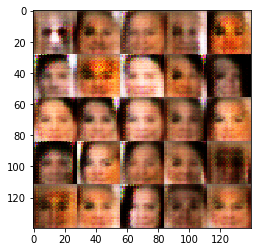

Epochs: 0/1. Discriminator Loss: 1.147 Generator Loss: 0.665
Epochs: 0/1. Discriminator Loss: 1.069 Generator Loss: 1.164
Epochs: 0/1. Discriminator Loss: 1.266 Generator Loss: 0.973
Epochs: 0/1. Discriminator Loss: 1.559 Generator Loss: 0.438
Epochs: 0/1. Discriminator Loss: 1.177 Generator Loss: 1.074
Epochs: 0/1. Discriminator Loss: 1.562 Generator Loss: 0.575
Epochs: 0/1. Discriminator Loss: 1.144 Generator Loss: 1.642
Epochs: 0/1. Discriminator Loss: 1.386 Generator Loss: 1.258
Epochs: 0/1. Discriminator Loss: 1.406 Generator Loss: 0.464
Epochs: 0/1. Discriminator Loss: 1.525 Generator Loss: 0.538


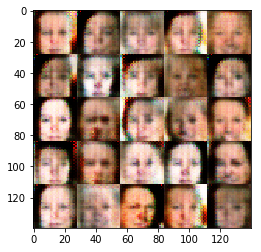

Epochs: 0/1. Discriminator Loss: 1.044 Generator Loss: 1.423
Epochs: 0/1. Discriminator Loss: 1.324 Generator Loss: 1.509
Epochs: 0/1. Discriminator Loss: 1.473 Generator Loss: 0.553
Epochs: 0/1. Discriminator Loss: 1.268 Generator Loss: 0.758
Epochs: 0/1. Discriminator Loss: 1.313 Generator Loss: 0.713
Epochs: 0/1. Discriminator Loss: 1.187 Generator Loss: 0.874
Epochs: 0/1. Discriminator Loss: 1.234 Generator Loss: 0.886
Epochs: 0/1. Discriminator Loss: 1.386 Generator Loss: 1.116
Epochs: 0/1. Discriminator Loss: 1.335 Generator Loss: 0.616
Epochs: 0/1. Discriminator Loss: 1.399 Generator Loss: 0.643


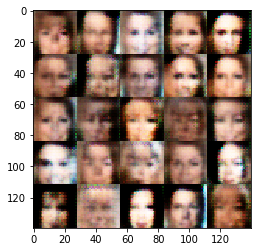

Epochs: 0/1. Discriminator Loss: 1.407 Generator Loss: 1.026
Epochs: 0/1. Discriminator Loss: 1.484 Generator Loss: 2.07
Epochs: 0/1. Discriminator Loss: 1.289 Generator Loss: 1.0
Epochs: 0/1. Discriminator Loss: 1.553 Generator Loss: 0.478
Epochs: 0/1. Discriminator Loss: 1.11 Generator Loss: 0.776
Epochs: 0/1. Discriminator Loss: 1.517 Generator Loss: 0.583
Epochs: 0/1. Discriminator Loss: 1.337 Generator Loss: 0.8
Epochs: 0/1. Discriminator Loss: 1.246 Generator Loss: 0.877
Epochs: 0/1. Discriminator Loss: 1.527 Generator Loss: 0.553
Epochs: 0/1. Discriminator Loss: 1.315 Generator Loss: 0.76


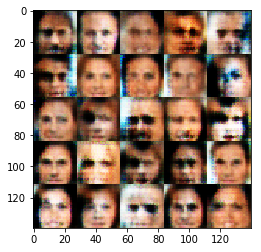

Epochs: 0/1. Discriminator Loss: 1.277 Generator Loss: 1.002
Epochs: 0/1. Discriminator Loss: 0.924 Generator Loss: 1.548
Epochs: 0/1. Discriminator Loss: 1.228 Generator Loss: 0.606
Epochs: 0/1. Discriminator Loss: 1.314 Generator Loss: 0.674
Epochs: 0/1. Discriminator Loss: 1.284 Generator Loss: 1.047
Epochs: 0/1. Discriminator Loss: 1.39 Generator Loss: 1.129
Epochs: 0/1. Discriminator Loss: 1.189 Generator Loss: 0.801
Epochs: 0/1. Discriminator Loss: 1.327 Generator Loss: 0.914
Epochs: 0/1. Discriminator Loss: 1.407 Generator Loss: 0.7
Epochs: 0/1. Discriminator Loss: 1.596 Generator Loss: 0.56


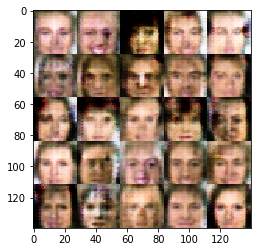

Epochs: 0/1. Discriminator Loss: 1.068 Generator Loss: 1.219
Epochs: 0/1. Discriminator Loss: 1.102 Generator Loss: 0.967
Epochs: 0/1. Discriminator Loss: 1.25 Generator Loss: 0.745
Epochs: 0/1. Discriminator Loss: 1.263 Generator Loss: 0.794
Epochs: 0/1. Discriminator Loss: 1.179 Generator Loss: 0.897
Epochs: 0/1. Discriminator Loss: 1.32 Generator Loss: 0.953
Epochs: 0/1. Discriminator Loss: 1.803 Generator Loss: 0.311
Epochs: 0/1. Discriminator Loss: 1.266 Generator Loss: 1.011
Epochs: 0/1. Discriminator Loss: 1.11 Generator Loss: 1.072
Epochs: 0/1. Discriminator Loss: 1.322 Generator Loss: 0.911


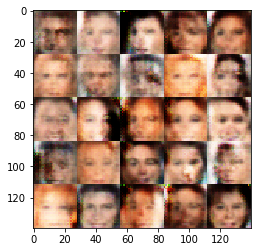

Epochs: 0/1. Discriminator Loss: 1.371 Generator Loss: 0.721
Epochs: 0/1. Discriminator Loss: 1.292 Generator Loss: 1.056
Epochs: 0/1. Discriminator Loss: 1.231 Generator Loss: 0.719
Epochs: 0/1. Discriminator Loss: 1.276 Generator Loss: 0.941
Epochs: 0/1. Discriminator Loss: 1.261 Generator Loss: 0.789
Epochs: 0/1. Discriminator Loss: 1.368 Generator Loss: 0.63
Epochs: 0/1. Discriminator Loss: 1.348 Generator Loss: 0.672
Epochs: 0/1. Discriminator Loss: 1.278 Generator Loss: 0.772
Epochs: 0/1. Discriminator Loss: 1.354 Generator Loss: 0.641
Epochs: 0/1. Discriminator Loss: 1.265 Generator Loss: 0.98


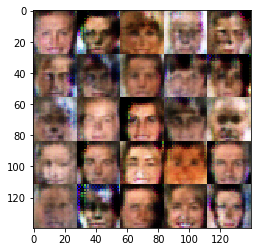

Epochs: 0/1. Discriminator Loss: 1.223 Generator Loss: 1.027
Epochs: 0/1. Discriminator Loss: 1.266 Generator Loss: 0.728
Epochs: 0/1. Discriminator Loss: 1.768 Generator Loss: 2.967
Epochs: 0/1. Discriminator Loss: 1.352 Generator Loss: 0.63
Epochs: 0/1. Discriminator Loss: 1.284 Generator Loss: 0.722
Epochs: 0/1. Discriminator Loss: 0.878 Generator Loss: 1.206
Epochs: 0/1. Discriminator Loss: 1.208 Generator Loss: 0.763
Epochs: 0/1. Discriminator Loss: 1.122 Generator Loss: 0.863
Epochs: 0/1. Discriminator Loss: 1.28 Generator Loss: 0.68
Epochs: 0/1. Discriminator Loss: 1.501 Generator Loss: 0.744


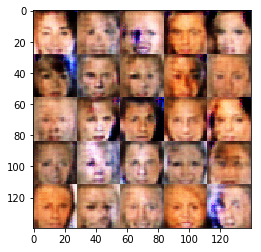

Epochs: 0/1. Discriminator Loss: 0.717 Generator Loss: 1.412
Epochs: 0/1. Discriminator Loss: 1.408 Generator Loss: 0.621
Epochs: 0/1. Discriminator Loss: 1.484 Generator Loss: 0.524
Epochs: 0/1. Discriminator Loss: 1.179 Generator Loss: 0.725
Epochs: 0/1. Discriminator Loss: 1.187 Generator Loss: 0.824
Epochs: 0/1. Discriminator Loss: 1.4 Generator Loss: 0.636
Epochs: 0/1. Discriminator Loss: 1.23 Generator Loss: 0.86
Epochs: 0/1. Discriminator Loss: 1.677 Generator Loss: 0.381
Epochs: 0/1. Discriminator Loss: 1.746 Generator Loss: 0.375
Epochs: 0/1. Discriminator Loss: 1.104 Generator Loss: 0.751


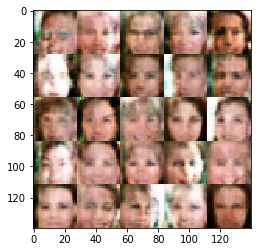

Epochs: 0/1. Discriminator Loss: 1.668 Generator Loss: 0.468
Epochs: 0/1. Discriminator Loss: 1.265 Generator Loss: 1.253
Epochs: 0/1. Discriminator Loss: 1.273 Generator Loss: 0.778
Epochs: 0/1. Discriminator Loss: 1.376 Generator Loss: 0.656
Epochs: 0/1. Discriminator Loss: 1.153 Generator Loss: 0.968
Epochs: 0/1. Discriminator Loss: 1.455 Generator Loss: 0.481
Epochs: 0/1. Discriminator Loss: 0.892 Generator Loss: 1.319
Epochs: 0/1. Discriminator Loss: 1.276 Generator Loss: 0.805
Epochs: 0/1. Discriminator Loss: 1.155 Generator Loss: 0.98
Epochs: 0/1. Discriminator Loss: 1.37 Generator Loss: 0.963


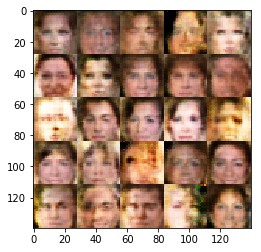

Epochs: 0/1. Discriminator Loss: 1.133 Generator Loss: 0.979
Epochs: 0/1. Discriminator Loss: 1.057 Generator Loss: 1.895
Epochs: 0/1. Discriminator Loss: 1.456 Generator Loss: 0.748
Epochs: 0/1. Discriminator Loss: 1.455 Generator Loss: 0.561
Epochs: 0/1. Discriminator Loss: 1.363 Generator Loss: 0.655
Epochs: 0/1. Discriminator Loss: 1.381 Generator Loss: 0.567
Epochs: 0/1. Discriminator Loss: 1.664 Generator Loss: 0.424
Epochs: 0/1. Discriminator Loss: 1.164 Generator Loss: 1.191
Epochs: 0/1. Discriminator Loss: 1.146 Generator Loss: 1.113
Epochs: 0/1. Discriminator Loss: 1.058 Generator Loss: 1.154


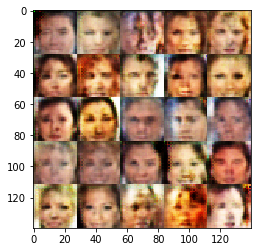

Epochs: 0/1. Discriminator Loss: 1.456 Generator Loss: 0.493
Epochs: 0/1. Discriminator Loss: 1.445 Generator Loss: 0.748
Epochs: 0/1. Discriminator Loss: 1.399 Generator Loss: 0.603
Epochs: 0/1. Discriminator Loss: 1.216 Generator Loss: 1.095
Epochs: 0/1. Discriminator Loss: 1.393 Generator Loss: 0.565
Epochs: 0/1. Discriminator Loss: 1.167 Generator Loss: 0.977
Epochs: 0/1. Discriminator Loss: 1.193 Generator Loss: 0.959
Epochs: 0/1. Discriminator Loss: 1.288 Generator Loss: 0.738
Epochs: 0/1. Discriminator Loss: 1.241 Generator Loss: 0.838
Epochs: 0/1. Discriminator Loss: 1.327 Generator Loss: 1.413


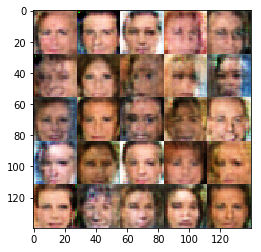

Epochs: 0/1. Discriminator Loss: 1.21 Generator Loss: 0.827
Epochs: 0/1. Discriminator Loss: 1.647 Generator Loss: 0.928
Epochs: 0/1. Discriminator Loss: 1.48 Generator Loss: 0.666
Epochs: 0/1. Discriminator Loss: 1.577 Generator Loss: 0.584
Epochs: 0/1. Discriminator Loss: 1.397 Generator Loss: 0.549
Epochs: 0/1. Discriminator Loss: 1.184 Generator Loss: 0.948
Epochs: 0/1. Discriminator Loss: 1.049 Generator Loss: 0.911
Epochs: 0/1. Discriminator Loss: 1.33 Generator Loss: 0.635
Epochs: 0/1. Discriminator Loss: 1.604 Generator Loss: 0.418
Epochs: 0/1. Discriminator Loss: 1.267 Generator Loss: 1.082


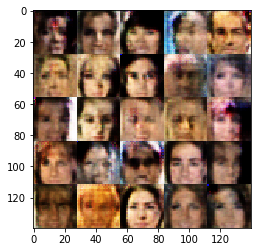

Epochs: 0/1. Discriminator Loss: 1.275 Generator Loss: 0.622
Epochs: 0/1. Discriminator Loss: 1.148 Generator Loss: 0.99
Epochs: 0/1. Discriminator Loss: 1.415 Generator Loss: 0.552
Epochs: 0/1. Discriminator Loss: 1.406 Generator Loss: 0.735
Epochs: 0/1. Discriminator Loss: 1.236 Generator Loss: 0.791
Epochs: 0/1. Discriminator Loss: 1.109 Generator Loss: 0.908
Epochs: 0/1. Discriminator Loss: 1.303 Generator Loss: 0.898
Epochs: 0/1. Discriminator Loss: 1.229 Generator Loss: 0.845
Epochs: 0/1. Discriminator Loss: 1.445 Generator Loss: 0.55
Epochs: 0/1. Discriminator Loss: 1.343 Generator Loss: 0.774


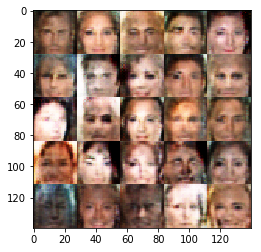

Epochs: 0/1. Discriminator Loss: 1.266 Generator Loss: 0.758
Epochs: 0/1. Discriminator Loss: 1.486 Generator Loss: 1.015
Epochs: 0/1. Discriminator Loss: 1.235 Generator Loss: 0.863
Epochs: 0/1. Discriminator Loss: 1.477 Generator Loss: 0.589
Epochs: 0/1. Discriminator Loss: 1.314 Generator Loss: 0.587
Epochs: 0/1. Discriminator Loss: 1.293 Generator Loss: 0.769
Epochs: 0/1. Discriminator Loss: 1.175 Generator Loss: 0.902
Epochs: 0/1. Discriminator Loss: 1.159 Generator Loss: 0.896
Epochs: 0/1. Discriminator Loss: 1.199 Generator Loss: 0.901
Epochs: 0/1. Discriminator Loss: 1.301 Generator Loss: 0.848


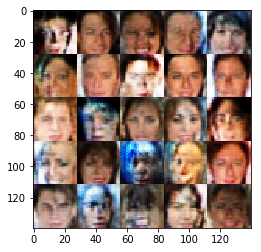

Epochs: 0/1. Discriminator Loss: 1.212 Generator Loss: 1.057
Epochs: 0/1. Discriminator Loss: 1.3 Generator Loss: 0.597
Epochs: 0/1. Discriminator Loss: 1.389 Generator Loss: 0.852
Epochs: 0/1. Discriminator Loss: 1.126 Generator Loss: 0.763
Epochs: 0/1. Discriminator Loss: 1.338 Generator Loss: 0.863
Epochs: 0/1. Discriminator Loss: 1.348 Generator Loss: 0.635
Epochs: 0/1. Discriminator Loss: 1.163 Generator Loss: 0.794
Epochs: 0/1. Discriminator Loss: 1.358 Generator Loss: 0.527
Epochs: 0/1. Discriminator Loss: 1.048 Generator Loss: 1.149
Epochs: 0/1. Discriminator Loss: 1.166 Generator Loss: 0.988


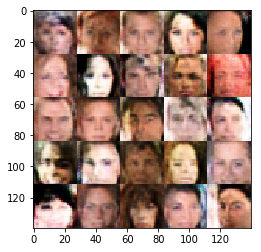

Epochs: 0/1. Discriminator Loss: 1.394 Generator Loss: 0.829
Epochs: 0/1. Discriminator Loss: 1.327 Generator Loss: 0.769
Epochs: 0/1. Discriminator Loss: 1.377 Generator Loss: 0.616
Epochs: 0/1. Discriminator Loss: 1.323 Generator Loss: 0.636
Epochs: 0/1. Discriminator Loss: 1.065 Generator Loss: 0.839
Epochs: 0/1. Discriminator Loss: 1.303 Generator Loss: 0.713
Epochs: 0/1. Discriminator Loss: 1.401 Generator Loss: 0.659
Epochs: 0/1. Discriminator Loss: 1.351 Generator Loss: 0.682
Epochs: 0/1. Discriminator Loss: 1.332 Generator Loss: 0.986
Epochs: 0/1. Discriminator Loss: 1.257 Generator Loss: 0.728


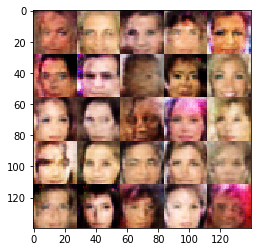

Epochs: 0/1. Discriminator Loss: 1.395 Generator Loss: 0.749
Epochs: 0/1. Discriminator Loss: 1.34 Generator Loss: 0.567
Epochs: 0/1. Discriminator Loss: 1.196 Generator Loss: 0.826
Epochs: 0/1. Discriminator Loss: 1.158 Generator Loss: 0.802
Epochs: 0/1. Discriminator Loss: 1.191 Generator Loss: 0.95
Epochs: 0/1. Discriminator Loss: 1.109 Generator Loss: 1.159
Epochs: 0/1. Discriminator Loss: 1.397 Generator Loss: 0.856
Epochs: 0/1. Discriminator Loss: 1.387 Generator Loss: 0.719
Epochs: 0/1. Discriminator Loss: 1.068 Generator Loss: 1.012
Epochs: 0/1. Discriminator Loss: 1.188 Generator Loss: 0.994


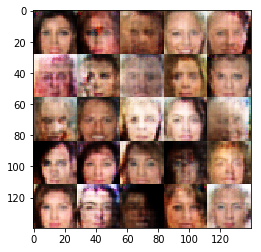

Epochs: 0/1. Discriminator Loss: 1.197 Generator Loss: 1.889
Epochs: 0/1. Discriminator Loss: 1.137 Generator Loss: 1.35
Epochs: 0/1. Discriminator Loss: 1.018 Generator Loss: 0.901
Epochs: 0/1. Discriminator Loss: 1.384 Generator Loss: 0.654
Epochs: 0/1. Discriminator Loss: 1.155 Generator Loss: 0.862
Epochs: 0/1. Discriminator Loss: 1.248 Generator Loss: 0.663
Epochs: 0/1. Discriminator Loss: 1.091 Generator Loss: 0.856
Epochs: 0/1. Discriminator Loss: 1.425 Generator Loss: 0.53
Epochs: 0/1. Discriminator Loss: 1.323 Generator Loss: 0.602
Epochs: 0/1. Discriminator Loss: 1.5 Generator Loss: 0.523


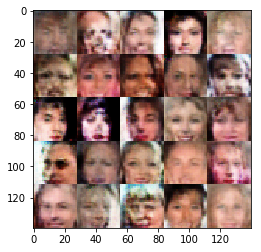

Epochs: 0/1. Discriminator Loss: 1.324 Generator Loss: 0.573
Epochs: 0/1. Discriminator Loss: 1.27 Generator Loss: 0.876
Epochs: 0/1. Discriminator Loss: 1.426 Generator Loss: 0.533
Epochs: 0/1. Discriminator Loss: 1.392 Generator Loss: 0.796
Epochs: 0/1. Discriminator Loss: 1.19 Generator Loss: 0.785
Epochs: 0/1. Discriminator Loss: 1.453 Generator Loss: 0.527
Epochs: 0/1. Discriminator Loss: 1.28 Generator Loss: 0.821
Epochs: 0/1. Discriminator Loss: 1.349 Generator Loss: 0.758
Epochs: 0/1. Discriminator Loss: 1.38 Generator Loss: 0.723
Epochs: 0/1. Discriminator Loss: 1.474 Generator Loss: 0.52


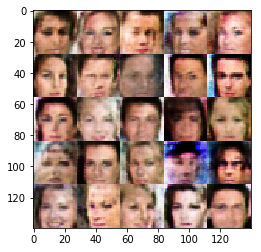

Epochs: 0/1. Discriminator Loss: 1.346 Generator Loss: 0.71
Epochs: 0/1. Discriminator Loss: 1.242 Generator Loss: 0.739
Epochs: 0/1. Discriminator Loss: 0.961 Generator Loss: 1.556
Epochs: 0/1. Discriminator Loss: 1.212 Generator Loss: 0.727
Epochs: 0/1. Discriminator Loss: 1.409 Generator Loss: 0.57
Epochs: 0/1. Discriminator Loss: 1.413 Generator Loss: 0.667
Epochs: 0/1. Discriminator Loss: 1.419 Generator Loss: 0.538
Epochs: 0/1. Discriminator Loss: 1.276 Generator Loss: 1.177
Epochs: 0/1. Discriminator Loss: 1.242 Generator Loss: 0.668
Epochs: 0/1. Discriminator Loss: 1.108 Generator Loss: 1.037


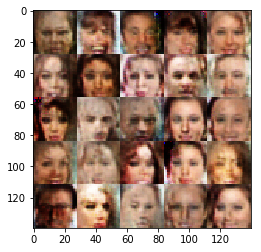

Epochs: 0/1. Discriminator Loss: 1.427 Generator Loss: 0.659
Epochs: 0/1. Discriminator Loss: 1.329 Generator Loss: 0.774
Epochs: 0/1. Discriminator Loss: 1.353 Generator Loss: 0.615
Epochs: 0/1. Discriminator Loss: 1.425 Generator Loss: 0.566
Epochs: 0/1. Discriminator Loss: 1.408 Generator Loss: 0.65
Epochs: 0/1. Discriminator Loss: 1.313 Generator Loss: 0.68
Epochs: 0/1. Discriminator Loss: 1.369 Generator Loss: 0.708
Epochs: 0/1. Discriminator Loss: 1.18 Generator Loss: 0.826
Epochs: 0/1. Discriminator Loss: 1.346 Generator Loss: 0.857
Epochs: 0/1. Discriminator Loss: 1.329 Generator Loss: 1.369


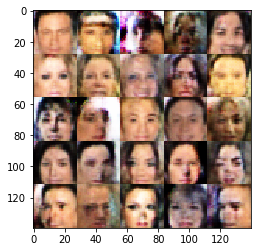

Epochs: 0/1. Discriminator Loss: 1.226 Generator Loss: 0.858
Epochs: 0/1. Discriminator Loss: 1.376 Generator Loss: 0.618
Epochs: 0/1. Discriminator Loss: 1.374 Generator Loss: 0.822
Epochs: 0/1. Discriminator Loss: 1.39 Generator Loss: 0.516
Epochs: 0/1. Discriminator Loss: 1.307 Generator Loss: 0.713
Epochs: 0/1. Discriminator Loss: 1.2 Generator Loss: 0.975
Epochs: 0/1. Discriminator Loss: 1.282 Generator Loss: 0.798
Epochs: 0/1. Discriminator Loss: 1.243 Generator Loss: 0.76
Epochs: 0/1. Discriminator Loss: 1.374 Generator Loss: 0.753
Epochs: 0/1. Discriminator Loss: 1.337 Generator Loss: 0.732


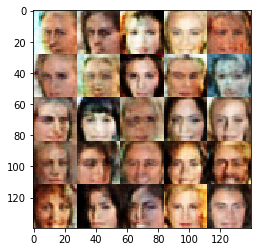

Epochs: 0/1. Discriminator Loss: 0.962 Generator Loss: 1.523
Epochs: 0/1. Discriminator Loss: 1.198 Generator Loss: 1.201
Epochs: 0/1. Discriminator Loss: 1.325 Generator Loss: 0.775
Epochs: 0/1. Discriminator Loss: 1.308 Generator Loss: 0.555
Epochs: 0/1. Discriminator Loss: 0.945 Generator Loss: 1.228
Epochs: 0/1. Discriminator Loss: 1.174 Generator Loss: 1.115
Epochs: 0/1. Discriminator Loss: 1.165 Generator Loss: 0.902
Epochs: 0/1. Discriminator Loss: 1.356 Generator Loss: 0.758
Epochs: 0/1. Discriminator Loss: 1.241 Generator Loss: 0.746
Epochs: 0/1. Discriminator Loss: 1.268 Generator Loss: 0.611


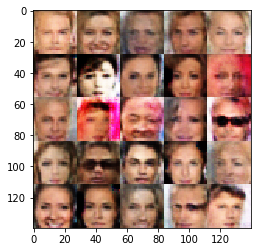

Epochs: 0/1. Discriminator Loss: 1.572 Generator Loss: 0.993
Epochs: 0/1. Discriminator Loss: 1.182 Generator Loss: 0.84
Epochs: 0/1. Discriminator Loss: 1.165 Generator Loss: 1.128
Epochs: 0/1. Discriminator Loss: 1.472 Generator Loss: 0.441
Epochs: 0/1. Discriminator Loss: 1.153 Generator Loss: 0.776
Epochs: 0/1. Discriminator Loss: 1.359 Generator Loss: 0.491
Epochs: 0/1. Discriminator Loss: 1.402 Generator Loss: 0.71
Epochs: 0/1. Discriminator Loss: 1.384 Generator Loss: 0.529
Epochs: 0/1. Discriminator Loss: 1.034 Generator Loss: 1.09
Epochs: 0/1. Discriminator Loss: 1.194 Generator Loss: 0.802


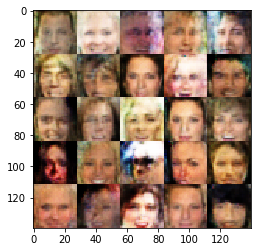

Epochs: 0/1. Discriminator Loss: 1.339 Generator Loss: 0.761
Epochs: 0/1. Discriminator Loss: 1.281 Generator Loss: 1.032
Epochs: 0/1. Discriminator Loss: 1.137 Generator Loss: 1.271
Epochs: 0/1. Discriminator Loss: 1.346 Generator Loss: 0.829
Epochs: 0/1. Discriminator Loss: 1.345 Generator Loss: 0.779
Epochs: 0/1. Discriminator Loss: 1.4 Generator Loss: 0.58
Epochs: 0/1. Discriminator Loss: 1.189 Generator Loss: 0.921
Epochs: 0/1. Discriminator Loss: 1.49 Generator Loss: 0.429
Epochs: 0/1. Discriminator Loss: 1.375 Generator Loss: 0.786
Epochs: 0/1. Discriminator Loss: 1.732 Generator Loss: 0.312


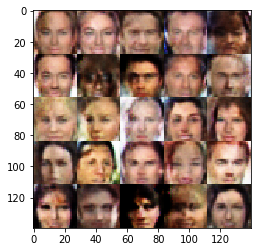

Epochs: 0/1. Discriminator Loss: 1.336 Generator Loss: 0.643
Epochs: 0/1. Discriminator Loss: 1.261 Generator Loss: 1.22
Epochs: 0/1. Discriminator Loss: 1.137 Generator Loss: 0.934
Epochs: 0/1. Discriminator Loss: 1.537 Generator Loss: 0.395
Epochs: 0/1. Discriminator Loss: 1.664 Generator Loss: 0.338
Epochs: 0/1. Discriminator Loss: 1.104 Generator Loss: 1.124
Epochs: 0/1. Discriminator Loss: 1.202 Generator Loss: 0.691
Epochs: 0/1. Discriminator Loss: 1.4 Generator Loss: 0.513
Epochs: 0/1. Discriminator Loss: 1.17 Generator Loss: 0.72
Epochs: 0/1. Discriminator Loss: 1.288 Generator Loss: 0.963


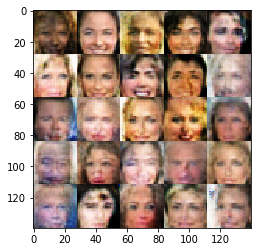

Epochs: 0/1. Discriminator Loss: 1.093 Generator Loss: 1.059
Epochs: 0/1. Discriminator Loss: 1.133 Generator Loss: 1.135
Epochs: 0/1. Discriminator Loss: 1.301 Generator Loss: 0.698
Epochs: 0/1. Discriminator Loss: 1.257 Generator Loss: 0.814
Epochs: 0/1. Discriminator Loss: 1.255 Generator Loss: 0.752
Epochs: 0/1. Discriminator Loss: 0.99 Generator Loss: 1.158
Epochs: 0/1. Discriminator Loss: 1.235 Generator Loss: 0.751
Epochs: 0/1. Discriminator Loss: 1.278 Generator Loss: 0.734
Epochs: 0/1. Discriminator Loss: 1.338 Generator Loss: 0.766
Epochs: 0/1. Discriminator Loss: 1.323 Generator Loss: 0.715


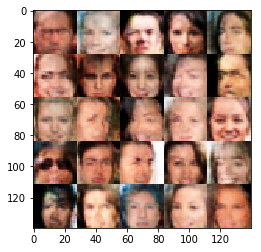

Epochs: 0/1. Discriminator Loss: 1.45 Generator Loss: 0.529
Epochs: 0/1. Discriminator Loss: 1.321 Generator Loss: 0.712
Epochs: 0/1. Discriminator Loss: 1.296 Generator Loss: 0.802
Epochs: 0/1. Discriminator Loss: 1.251 Generator Loss: 0.688
Epochs: 0/1. Discriminator Loss: 1.027 Generator Loss: 0.879
Epochs: 0/1. Discriminator Loss: 1.278 Generator Loss: 1.417
Epochs: 0/1. Discriminator Loss: 1.222 Generator Loss: 0.799
Epochs: 0/1. Discriminator Loss: 1.595 Generator Loss: 0.358
Epochs: 0/1. Discriminator Loss: 1.094 Generator Loss: 0.874
Epochs: 0/1. Discriminator Loss: 1.406 Generator Loss: 0.496


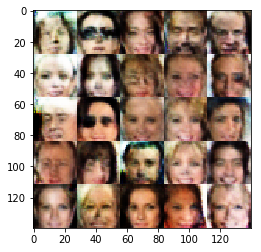

Epochs: 0/1. Discriminator Loss: 1.226 Generator Loss: 0.781
Epochs: 0/1. Discriminator Loss: 1.224 Generator Loss: 0.76
Epochs: 0/1. Discriminator Loss: 1.157 Generator Loss: 0.757
Epochs: 0/1. Discriminator Loss: 1.244 Generator Loss: 0.637
Epochs: 0/1. Discriminator Loss: 1.346 Generator Loss: 1.09
Epochs: 0/1. Discriminator Loss: 1.375 Generator Loss: 0.695
Epochs: 1/1. Discriminator Loss: 1.201 Generator Loss: 0.866
Epochs: 1/1. Discriminator Loss: 1.368 Generator Loss: 0.55
Epochs: 1/1. Discriminator Loss: 1.321 Generator Loss: 0.584
Epochs: 1/1. Discriminator Loss: 1.454 Generator Loss: 0.489


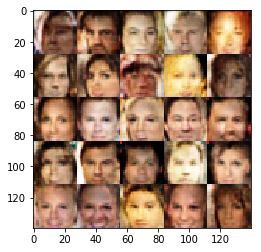

Epochs: 1/1. Discriminator Loss: 1.397 Generator Loss: 0.807
Epochs: 1/1. Discriminator Loss: 1.314 Generator Loss: 0.607
Epochs: 1/1. Discriminator Loss: 1.155 Generator Loss: 0.866
Epochs: 1/1. Discriminator Loss: 1.163 Generator Loss: 0.881
Epochs: 1/1. Discriminator Loss: 1.18 Generator Loss: 1.082
Epochs: 1/1. Discriminator Loss: 1.233 Generator Loss: 0.923
Epochs: 1/1. Discriminator Loss: 1.086 Generator Loss: 0.838
Epochs: 1/1. Discriminator Loss: 1.19 Generator Loss: 1.264
Epochs: 1/1. Discriminator Loss: 1.141 Generator Loss: 0.9
Epochs: 1/1. Discriminator Loss: 1.065 Generator Loss: 0.886


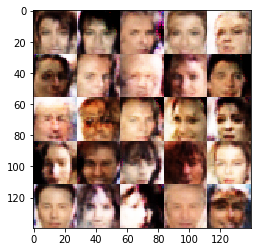

Epochs: 1/1. Discriminator Loss: 1.194 Generator Loss: 0.724
Epochs: 1/1. Discriminator Loss: 1.615 Generator Loss: 0.354
Epochs: 1/1. Discriminator Loss: 1.315 Generator Loss: 0.681
Epochs: 1/1. Discriminator Loss: 1.59 Generator Loss: 0.38
Epochs: 1/1. Discriminator Loss: 1.173 Generator Loss: 0.945
Epochs: 1/1. Discriminator Loss: 1.361 Generator Loss: 0.62
Epochs: 1/1. Discriminator Loss: 1.328 Generator Loss: 0.73
Epochs: 1/1. Discriminator Loss: 1.242 Generator Loss: 0.804
Epochs: 1/1. Discriminator Loss: 1.253 Generator Loss: 0.969
Epochs: 1/1. Discriminator Loss: 1.4 Generator Loss: 0.715


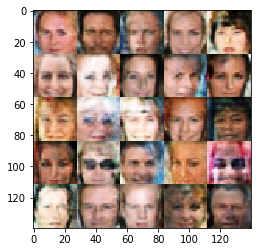

Epochs: 1/1. Discriminator Loss: 1.212 Generator Loss: 0.795
Epochs: 1/1. Discriminator Loss: 1.032 Generator Loss: 0.999
Epochs: 1/1. Discriminator Loss: 1.228 Generator Loss: 1.186
Epochs: 1/1. Discriminator Loss: 1.105 Generator Loss: 1.167
Epochs: 1/1. Discriminator Loss: 1.302 Generator Loss: 0.688
Epochs: 1/1. Discriminator Loss: 2.017 Generator Loss: 2.066
Epochs: 1/1. Discriminator Loss: 1.34 Generator Loss: 0.654
Epochs: 1/1. Discriminator Loss: 1.238 Generator Loss: 0.794
Epochs: 1/1. Discriminator Loss: 1.278 Generator Loss: 0.753
Epochs: 1/1. Discriminator Loss: 1.217 Generator Loss: 0.743


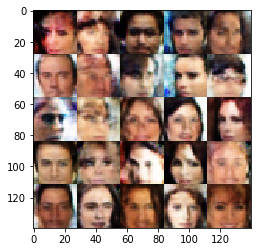

Epochs: 1/1. Discriminator Loss: 1.213 Generator Loss: 0.83
Epochs: 1/1. Discriminator Loss: 1.359 Generator Loss: 0.637
Epochs: 1/1. Discriminator Loss: 1.413 Generator Loss: 0.473
Epochs: 1/1. Discriminator Loss: 1.238 Generator Loss: 1.252
Epochs: 1/1. Discriminator Loss: 1.123 Generator Loss: 0.958
Epochs: 1/1. Discriminator Loss: 1.366 Generator Loss: 0.661
Epochs: 1/1. Discriminator Loss: 1.242 Generator Loss: 0.762
Epochs: 1/1. Discriminator Loss: 1.291 Generator Loss: 0.691
Epochs: 1/1. Discriminator Loss: 1.335 Generator Loss: 0.896
Epochs: 1/1. Discriminator Loss: 1.402 Generator Loss: 0.683


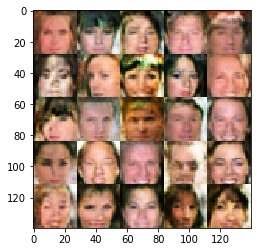

Epochs: 1/1. Discriminator Loss: 1.344 Generator Loss: 0.602
Epochs: 1/1. Discriminator Loss: 1.288 Generator Loss: 0.821
Epochs: 1/1. Discriminator Loss: 1.236 Generator Loss: 0.768
Epochs: 1/1. Discriminator Loss: 1.295 Generator Loss: 0.691
Epochs: 1/1. Discriminator Loss: 1.2 Generator Loss: 0.762
Epochs: 1/1. Discriminator Loss: 1.521 Generator Loss: 0.413
Epochs: 1/1. Discriminator Loss: 1.411 Generator Loss: 0.537
Epochs: 1/1. Discriminator Loss: 1.416 Generator Loss: 0.52
Epochs: 1/1. Discriminator Loss: 1.134 Generator Loss: 1.336
Epochs: 1/1. Discriminator Loss: 1.141 Generator Loss: 0.992


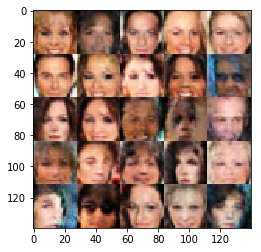

Epochs: 1/1. Discriminator Loss: 1.336 Generator Loss: 0.711
Epochs: 1/1. Discriminator Loss: 1.384 Generator Loss: 0.496
Epochs: 1/1. Discriminator Loss: 1.252 Generator Loss: 0.827
Epochs: 1/1. Discriminator Loss: 1.095 Generator Loss: 1.043
Epochs: 1/1. Discriminator Loss: 1.381 Generator Loss: 0.63
Epochs: 1/1. Discriminator Loss: 1.129 Generator Loss: 1.007
Epochs: 1/1. Discriminator Loss: 1.592 Generator Loss: 1.382
Epochs: 1/1. Discriminator Loss: 1.14 Generator Loss: 0.916
Epochs: 1/1. Discriminator Loss: 1.257 Generator Loss: 0.779
Epochs: 1/1. Discriminator Loss: 1.269 Generator Loss: 0.809


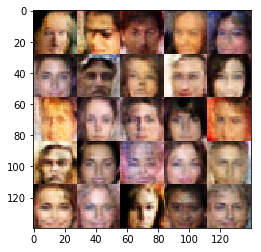

Epochs: 1/1. Discriminator Loss: 1.253 Generator Loss: 1.108
Epochs: 1/1. Discriminator Loss: 1.235 Generator Loss: 0.911
Epochs: 1/1. Discriminator Loss: 1.239 Generator Loss: 0.868
Epochs: 1/1. Discriminator Loss: 1.371 Generator Loss: 0.705
Epochs: 1/1. Discriminator Loss: 1.275 Generator Loss: 0.703
Epochs: 1/1. Discriminator Loss: 1.368 Generator Loss: 0.765
Epochs: 1/1. Discriminator Loss: 1.276 Generator Loss: 0.94
Epochs: 1/1. Discriminator Loss: 1.243 Generator Loss: 0.666
Epochs: 1/1. Discriminator Loss: 1.241 Generator Loss: 1.195
Epochs: 1/1. Discriminator Loss: 1.261 Generator Loss: 0.684


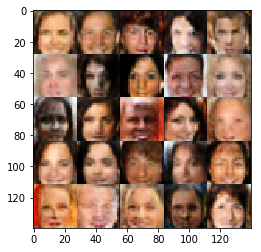

Epochs: 1/1. Discriminator Loss: 1.166 Generator Loss: 0.871
Epochs: 1/1. Discriminator Loss: 1.138 Generator Loss: 0.763
Epochs: 1/1. Discriminator Loss: 1.302 Generator Loss: 1.299
Epochs: 1/1. Discriminator Loss: 1.282 Generator Loss: 0.665
Epochs: 1/1. Discriminator Loss: 1.21 Generator Loss: 0.782
Epochs: 1/1. Discriminator Loss: 1.248 Generator Loss: 0.743
Epochs: 1/1. Discriminator Loss: 1.264 Generator Loss: 0.95
Epochs: 1/1. Discriminator Loss: 1.321 Generator Loss: 0.551
Epochs: 1/1. Discriminator Loss: 1.161 Generator Loss: 0.78
Epochs: 1/1. Discriminator Loss: 1.286 Generator Loss: 0.829


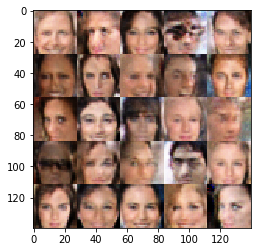

Epochs: 1/1. Discriminator Loss: 1.24 Generator Loss: 0.777
Epochs: 1/1. Discriminator Loss: 1.305 Generator Loss: 0.752
Epochs: 1/1. Discriminator Loss: 1.423 Generator Loss: 0.558
Epochs: 1/1. Discriminator Loss: 1.15 Generator Loss: 0.937
Epochs: 1/1. Discriminator Loss: 1.378 Generator Loss: 0.599
Epochs: 1/1. Discriminator Loss: 1.313 Generator Loss: 0.655
Epochs: 1/1. Discriminator Loss: 1.472 Generator Loss: 0.929
Epochs: 1/1. Discriminator Loss: 1.326 Generator Loss: 0.643
Epochs: 1/1. Discriminator Loss: 1.243 Generator Loss: 0.823
Epochs: 1/1. Discriminator Loss: 1.533 Generator Loss: 1.151


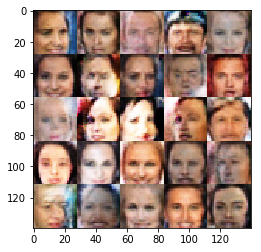

Epochs: 1/1. Discriminator Loss: 1.256 Generator Loss: 0.897
Epochs: 1/1. Discriminator Loss: 1.295 Generator Loss: 0.762
Epochs: 1/1. Discriminator Loss: 1.292 Generator Loss: 0.664
Epochs: 1/1. Discriminator Loss: 1.21 Generator Loss: 0.829
Epochs: 1/1. Discriminator Loss: 1.236 Generator Loss: 0.76
Epochs: 1/1. Discriminator Loss: 1.195 Generator Loss: 0.827
Epochs: 1/1. Discriminator Loss: 1.218 Generator Loss: 0.81
Epochs: 1/1. Discriminator Loss: 1.253 Generator Loss: 0.868
Epochs: 1/1. Discriminator Loss: 1.153 Generator Loss: 0.893
Epochs: 1/1. Discriminator Loss: 1.386 Generator Loss: 0.79


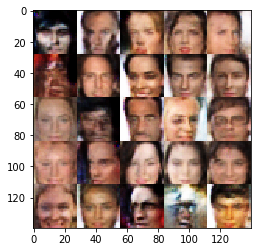

Epochs: 1/1. Discriminator Loss: 1.31 Generator Loss: 0.638
Epochs: 1/1. Discriminator Loss: 1.368 Generator Loss: 0.723
Epochs: 1/1. Discriminator Loss: 1.219 Generator Loss: 0.838
Epochs: 1/1. Discriminator Loss: 1.299 Generator Loss: 0.867
Epochs: 1/1. Discriminator Loss: 1.197 Generator Loss: 0.933
Epochs: 1/1. Discriminator Loss: 1.16 Generator Loss: 0.891
Epochs: 1/1. Discriminator Loss: 1.132 Generator Loss: 1.034
Epochs: 1/1. Discriminator Loss: 1.48 Generator Loss: 0.488
Epochs: 1/1. Discriminator Loss: 1.286 Generator Loss: 0.707
Epochs: 1/1. Discriminator Loss: 1.3 Generator Loss: 0.685


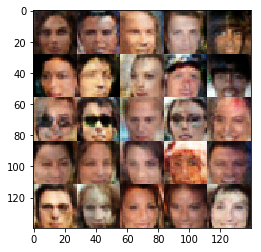

Epochs: 1/1. Discriminator Loss: 1.165 Generator Loss: 1.415
Epochs: 1/1. Discriminator Loss: 1.467 Generator Loss: 0.66
Epochs: 1/1. Discriminator Loss: 1.243 Generator Loss: 0.957
Epochs: 1/1. Discriminator Loss: 1.188 Generator Loss: 0.855
Epochs: 1/1. Discriminator Loss: 1.281 Generator Loss: 0.648
Epochs: 1/1. Discriminator Loss: 1.439 Generator Loss: 0.521
Epochs: 1/1. Discriminator Loss: 1.143 Generator Loss: 1.039
Epochs: 1/1. Discriminator Loss: 1.112 Generator Loss: 0.979
Epochs: 1/1. Discriminator Loss: 1.291 Generator Loss: 0.758
Epochs: 1/1. Discriminator Loss: 1.167 Generator Loss: 0.974


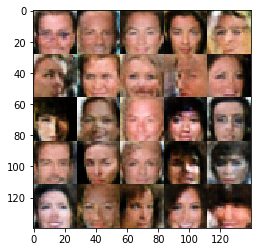

Epochs: 1/1. Discriminator Loss: 1.278 Generator Loss: 0.673
Epochs: 1/1. Discriminator Loss: 1.233 Generator Loss: 0.799
Epochs: 1/1. Discriminator Loss: 1.202 Generator Loss: 0.838
Epochs: 1/1. Discriminator Loss: 1.334 Generator Loss: 0.971
Epochs: 1/1. Discriminator Loss: 1.294 Generator Loss: 0.809
Epochs: 1/1. Discriminator Loss: 1.195 Generator Loss: 1.136
Epochs: 1/1. Discriminator Loss: 1.21 Generator Loss: 0.899
Epochs: 1/1. Discriminator Loss: 1.381 Generator Loss: 0.66
Epochs: 1/1. Discriminator Loss: 1.281 Generator Loss: 0.695
Epochs: 1/1. Discriminator Loss: 1.256 Generator Loss: 0.714


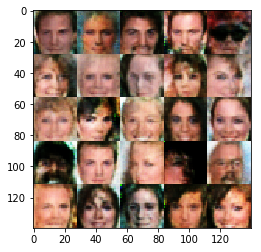

Epochs: 1/1. Discriminator Loss: 1.231 Generator Loss: 0.731
Epochs: 1/1. Discriminator Loss: 1.226 Generator Loss: 0.815
Epochs: 1/1. Discriminator Loss: 1.143 Generator Loss: 0.819
Epochs: 1/1. Discriminator Loss: 1.18 Generator Loss: 0.906
Epochs: 1/1. Discriminator Loss: 1.472 Generator Loss: 0.644
Epochs: 1/1. Discriminator Loss: 1.375 Generator Loss: 0.745
Epochs: 1/1. Discriminator Loss: 1.298 Generator Loss: 0.777
Epochs: 1/1. Discriminator Loss: 1.048 Generator Loss: 0.85
Epochs: 1/1. Discriminator Loss: 1.609 Generator Loss: 0.365
Epochs: 1/1. Discriminator Loss: 1.307 Generator Loss: 0.762


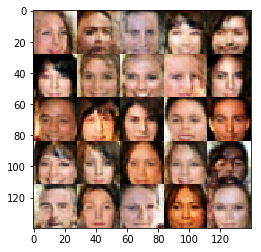

Epochs: 1/1. Discriminator Loss: 1.185 Generator Loss: 0.94
Epochs: 1/1. Discriminator Loss: 1.293 Generator Loss: 0.731
Epochs: 1/1. Discriminator Loss: 1.284 Generator Loss: 0.799
Epochs: 1/1. Discriminator Loss: 1.381 Generator Loss: 0.553
Epochs: 1/1. Discriminator Loss: 1.258 Generator Loss: 1.022
Epochs: 1/1. Discriminator Loss: 1.268 Generator Loss: 0.748
Epochs: 1/1. Discriminator Loss: 1.618 Generator Loss: 0.37
Epochs: 1/1. Discriminator Loss: 1.309 Generator Loss: 0.68
Epochs: 1/1. Discriminator Loss: 1.374 Generator Loss: 0.733
Epochs: 1/1. Discriminator Loss: 1.202 Generator Loss: 0.874


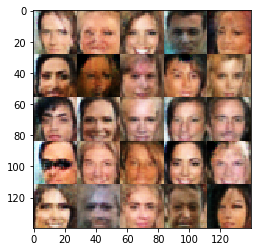

Epochs: 1/1. Discriminator Loss: 1.328 Generator Loss: 0.735
Epochs: 1/1. Discriminator Loss: 1.496 Generator Loss: 0.515
Epochs: 1/1. Discriminator Loss: 1.15 Generator Loss: 0.881
Epochs: 1/1. Discriminator Loss: 1.033 Generator Loss: 1.051
Epochs: 1/1. Discriminator Loss: 1.348 Generator Loss: 0.566
Epochs: 1/1. Discriminator Loss: 1.294 Generator Loss: 0.778
Epochs: 1/1. Discriminator Loss: 1.388 Generator Loss: 0.715
Epochs: 1/1. Discriminator Loss: 1.183 Generator Loss: 0.772
Epochs: 1/1. Discriminator Loss: 1.227 Generator Loss: 0.979
Epochs: 1/1. Discriminator Loss: 1.205 Generator Loss: 0.883


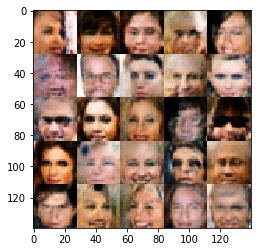

Epochs: 1/1. Discriminator Loss: 1.427 Generator Loss: 0.653
Epochs: 1/1. Discriminator Loss: 1.381 Generator Loss: 0.906
Epochs: 1/1. Discriminator Loss: 1.148 Generator Loss: 0.951
Epochs: 1/1. Discriminator Loss: 1.316 Generator Loss: 0.69
Epochs: 1/1. Discriminator Loss: 1.353 Generator Loss: 0.662
Epochs: 1/1. Discriminator Loss: 1.309 Generator Loss: 0.632
Epochs: 1/1. Discriminator Loss: 1.313 Generator Loss: 0.839
Epochs: 1/1. Discriminator Loss: 1.279 Generator Loss: 0.712
Epochs: 1/1. Discriminator Loss: 1.071 Generator Loss: 1.058
Epochs: 1/1. Discriminator Loss: 0.981 Generator Loss: 1.205


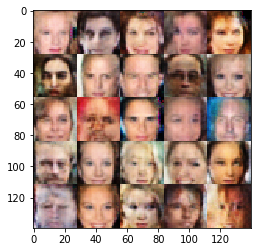

Epochs: 1/1. Discriminator Loss: 1.033 Generator Loss: 0.864
Epochs: 1/1. Discriminator Loss: 1.365 Generator Loss: 0.563
Epochs: 1/1. Discriminator Loss: 1.079 Generator Loss: 1.25
Epochs: 1/1. Discriminator Loss: 1.238 Generator Loss: 1.436
Epochs: 1/1. Discriminator Loss: 1.267 Generator Loss: 0.754
Epochs: 1/1. Discriminator Loss: 1.268 Generator Loss: 1.726
Epochs: 1/1. Discriminator Loss: 1.242 Generator Loss: 0.733
Epochs: 1/1. Discriminator Loss: 1.38 Generator Loss: 0.553
Epochs: 1/1. Discriminator Loss: 1.176 Generator Loss: 1.096
Epochs: 1/1. Discriminator Loss: 1.239 Generator Loss: 0.639


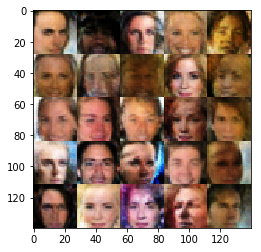

Epochs: 1/1. Discriminator Loss: 1.196 Generator Loss: 0.825
Epochs: 1/1. Discriminator Loss: 1.276 Generator Loss: 0.764
Epochs: 1/1. Discriminator Loss: 1.315 Generator Loss: 0.864
Epochs: 1/1. Discriminator Loss: 1.255 Generator Loss: 0.827
Epochs: 1/1. Discriminator Loss: 1.235 Generator Loss: 1.051
Epochs: 1/1. Discriminator Loss: 1.297 Generator Loss: 0.671
Epochs: 1/1. Discriminator Loss: 1.306 Generator Loss: 0.83
Epochs: 1/1. Discriminator Loss: 1.156 Generator Loss: 0.826
Epochs: 1/1. Discriminator Loss: 1.113 Generator Loss: 1.01
Epochs: 1/1. Discriminator Loss: 1.313 Generator Loss: 0.774


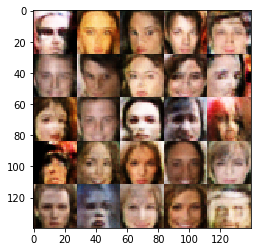

Epochs: 1/1. Discriminator Loss: 1.481 Generator Loss: 0.613
Epochs: 1/1. Discriminator Loss: 1.269 Generator Loss: 0.915
Epochs: 1/1. Discriminator Loss: 1.188 Generator Loss: 0.927
Epochs: 1/1. Discriminator Loss: 1.262 Generator Loss: 0.795
Epochs: 1/1. Discriminator Loss: 1.216 Generator Loss: 1.074
Epochs: 1/1. Discriminator Loss: 1.434 Generator Loss: 0.53
Epochs: 1/1. Discriminator Loss: 1.21 Generator Loss: 0.968
Epochs: 1/1. Discriminator Loss: 1.349 Generator Loss: 0.947
Epochs: 1/1. Discriminator Loss: 1.548 Generator Loss: 0.414
Epochs: 1/1. Discriminator Loss: 1.204 Generator Loss: 0.838


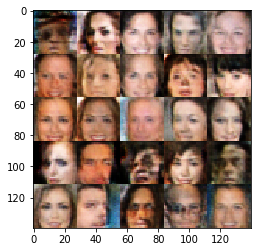

Epochs: 1/1. Discriminator Loss: 1.301 Generator Loss: 0.687
Epochs: 1/1. Discriminator Loss: 1.39 Generator Loss: 0.646
Epochs: 1/1. Discriminator Loss: 1.226 Generator Loss: 0.745
Epochs: 1/1. Discriminator Loss: 1.329 Generator Loss: 0.716
Epochs: 1/1. Discriminator Loss: 1.24 Generator Loss: 0.93
Epochs: 1/1. Discriminator Loss: 1.346 Generator Loss: 0.802
Epochs: 1/1. Discriminator Loss: 1.463 Generator Loss: 0.559
Epochs: 1/1. Discriminator Loss: 1.314 Generator Loss: 0.617
Epochs: 1/1. Discriminator Loss: 1.214 Generator Loss: 0.821
Epochs: 1/1. Discriminator Loss: 1.239 Generator Loss: 0.979


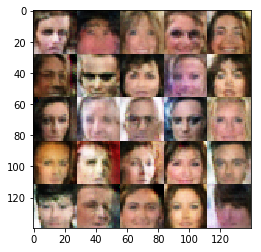

Epochs: 1/1. Discriminator Loss: 1.241 Generator Loss: 0.804
Epochs: 1/1. Discriminator Loss: 1.178 Generator Loss: 0.957
Epochs: 1/1. Discriminator Loss: 1.187 Generator Loss: 0.893
Epochs: 1/1. Discriminator Loss: 1.233 Generator Loss: 0.902
Epochs: 1/1. Discriminator Loss: 1.353 Generator Loss: 0.639
Epochs: 1/1. Discriminator Loss: 1.41 Generator Loss: 0.622
Epochs: 1/1. Discriminator Loss: 1.192 Generator Loss: 0.82
Epochs: 1/1. Discriminator Loss: 1.42 Generator Loss: 1.173
Epochs: 1/1. Discriminator Loss: 1.215 Generator Loss: 0.826
Epochs: 1/1. Discriminator Loss: 1.174 Generator Loss: 0.854


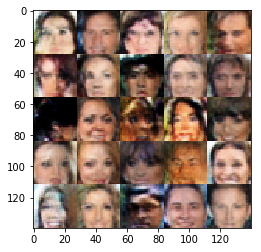

Epochs: 1/1. Discriminator Loss: 1.249 Generator Loss: 0.796
Epochs: 1/1. Discriminator Loss: 1.272 Generator Loss: 1.01
Epochs: 1/1. Discriminator Loss: 1.268 Generator Loss: 0.797
Epochs: 1/1. Discriminator Loss: 1.31 Generator Loss: 0.77
Epochs: 1/1. Discriminator Loss: 1.408 Generator Loss: 0.737
Epochs: 1/1. Discriminator Loss: 1.014 Generator Loss: 1.11
Epochs: 1/1. Discriminator Loss: 1.082 Generator Loss: 0.972
Epochs: 1/1. Discriminator Loss: 1.251 Generator Loss: 1.045
Epochs: 1/1. Discriminator Loss: 1.344 Generator Loss: 0.539
Epochs: 1/1. Discriminator Loss: 1.346 Generator Loss: 0.619


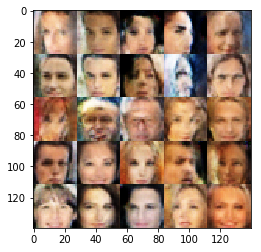

Epochs: 1/1. Discriminator Loss: 1.237 Generator Loss: 0.781
Epochs: 1/1. Discriminator Loss: 1.217 Generator Loss: 0.771
Epochs: 1/1. Discriminator Loss: 1.27 Generator Loss: 0.822
Epochs: 1/1. Discriminator Loss: 1.348 Generator Loss: 1.041
Epochs: 1/1. Discriminator Loss: 1.558 Generator Loss: 0.406
Epochs: 1/1. Discriminator Loss: 1.038 Generator Loss: 1.118
Epochs: 1/1. Discriminator Loss: 1.27 Generator Loss: 0.696
Epochs: 1/1. Discriminator Loss: 1.232 Generator Loss: 0.745
Epochs: 1/1. Discriminator Loss: 1.336 Generator Loss: 1.13
Epochs: 1/1. Discriminator Loss: 1.395 Generator Loss: 0.646


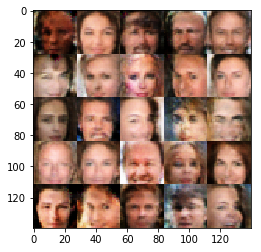

Epochs: 1/1. Discriminator Loss: 1.195 Generator Loss: 0.832
Epochs: 1/1. Discriminator Loss: 1.263 Generator Loss: 0.646
Epochs: 1/1. Discriminator Loss: 1.339 Generator Loss: 0.72
Epochs: 1/1. Discriminator Loss: 1.307 Generator Loss: 0.717
Epochs: 1/1. Discriminator Loss: 1.033 Generator Loss: 0.744
Epochs: 1/1. Discriminator Loss: 1.27 Generator Loss: 0.699
Epochs: 1/1. Discriminator Loss: 1.262 Generator Loss: 0.808
Epochs: 1/1. Discriminator Loss: 1.208 Generator Loss: 0.777
Epochs: 1/1. Discriminator Loss: 1.344 Generator Loss: 0.752
Epochs: 1/1. Discriminator Loss: 1.451 Generator Loss: 0.475


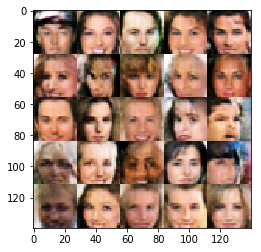

Epochs: 1/1. Discriminator Loss: 1.309 Generator Loss: 0.614
Epochs: 1/1. Discriminator Loss: 1.257 Generator Loss: 0.682
Epochs: 1/1. Discriminator Loss: 1.148 Generator Loss: 0.949
Epochs: 1/1. Discriminator Loss: 1.234 Generator Loss: 0.872
Epochs: 1/1. Discriminator Loss: 1.379 Generator Loss: 0.656
Epochs: 1/1. Discriminator Loss: 1.647 Generator Loss: 0.35
Epochs: 1/1. Discriminator Loss: 1.228 Generator Loss: 0.733
Epochs: 1/1. Discriminator Loss: 1.428 Generator Loss: 0.834
Epochs: 1/1. Discriminator Loss: 1.212 Generator Loss: 0.883
Epochs: 1/1. Discriminator Loss: 1.204 Generator Loss: 0.795


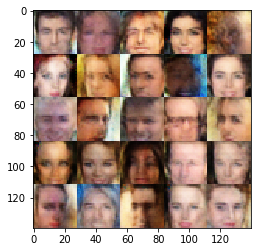

Epochs: 1/1. Discriminator Loss: 1.272 Generator Loss: 0.614
Epochs: 1/1. Discriminator Loss: 1.261 Generator Loss: 0.916
Epochs: 1/1. Discriminator Loss: 1.345 Generator Loss: 0.761
Epochs: 1/1. Discriminator Loss: 1.219 Generator Loss: 0.772
Epochs: 1/1. Discriminator Loss: 1.297 Generator Loss: 0.719
Epochs: 1/1. Discriminator Loss: 1.398 Generator Loss: 0.837
Epochs: 1/1. Discriminator Loss: 1.28 Generator Loss: 1.044
Epochs: 1/1. Discriminator Loss: 1.262 Generator Loss: 0.864
Epochs: 1/1. Discriminator Loss: 1.172 Generator Loss: 0.748
Epochs: 1/1. Discriminator Loss: 1.294 Generator Loss: 0.66


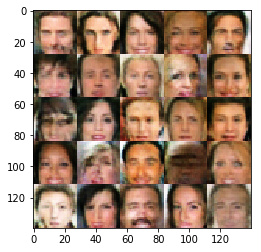

Epochs: 1/1. Discriminator Loss: 1.212 Generator Loss: 0.959
Epochs: 1/1. Discriminator Loss: 1.276 Generator Loss: 0.847
Epochs: 1/1. Discriminator Loss: 1.094 Generator Loss: 0.989
Epochs: 1/1. Discriminator Loss: 1.338 Generator Loss: 0.667
Epochs: 1/1. Discriminator Loss: 1.296 Generator Loss: 0.684
Epochs: 1/1. Discriminator Loss: 1.192 Generator Loss: 0.813
Epochs: 1/1. Discriminator Loss: 1.3 Generator Loss: 0.65
Epochs: 1/1. Discriminator Loss: 1.275 Generator Loss: 0.704
Epochs: 1/1. Discriminator Loss: 1.33 Generator Loss: 1.102
Epochs: 1/1. Discriminator Loss: 1.174 Generator Loss: 0.966


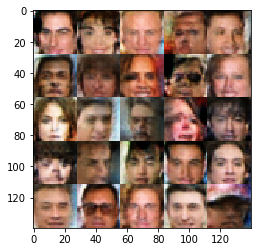

Epochs: 1/1. Discriminator Loss: 1.218 Generator Loss: 0.95
Epochs: 1/1. Discriminator Loss: 1.211 Generator Loss: 0.884
Epochs: 1/1. Discriminator Loss: 1.345 Generator Loss: 0.591
Epochs: 1/1. Discriminator Loss: 1.204 Generator Loss: 0.819
Epochs: 1/1. Discriminator Loss: 1.248 Generator Loss: 0.759
Epochs: 1/1. Discriminator Loss: 1.153 Generator Loss: 0.795
Epochs: 1/1. Discriminator Loss: 1.215 Generator Loss: 0.856
Epochs: 1/1. Discriminator Loss: 1.13 Generator Loss: 0.825
Epochs: 1/1. Discriminator Loss: 1.12 Generator Loss: 1.009
Epochs: 1/1. Discriminator Loss: 1.352 Generator Loss: 0.592


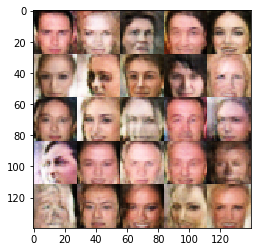

Epochs: 1/1. Discriminator Loss: 1.392 Generator Loss: 0.594
Epochs: 1/1. Discriminator Loss: 1.49 Generator Loss: 0.62
Epochs: 1/1. Discriminator Loss: 1.335 Generator Loss: 0.642
Epochs: 1/1. Discriminator Loss: 1.279 Generator Loss: 0.608
Epochs: 1/1. Discriminator Loss: 1.25 Generator Loss: 0.838
Epochs: 1/1. Discriminator Loss: 1.203 Generator Loss: 0.771
Epochs: 1/1. Discriminator Loss: 1.282 Generator Loss: 1.013
Epochs: 1/1. Discriminator Loss: 1.691 Generator Loss: 0.339
Epochs: 1/1. Discriminator Loss: 1.177 Generator Loss: 0.732
Epochs: 1/1. Discriminator Loss: 1.314 Generator Loss: 0.796


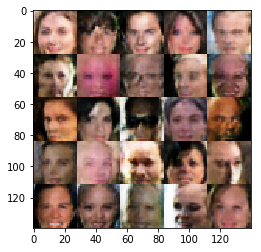

Epochs: 1/1. Discriminator Loss: 1.319 Generator Loss: 0.757
Epochs: 1/1. Discriminator Loss: 1.141 Generator Loss: 0.878
Epochs: 1/1. Discriminator Loss: 1.318 Generator Loss: 0.653
Epochs: 1/1. Discriminator Loss: 1.211 Generator Loss: 0.774
Epochs: 1/1. Discriminator Loss: 1.218 Generator Loss: 0.918
Epochs: 1/1. Discriminator Loss: 1.204 Generator Loss: 0.646
Epochs: 1/1. Discriminator Loss: 1.236 Generator Loss: 0.74
Epochs: 1/1. Discriminator Loss: 1.261 Generator Loss: 0.777
Epochs: 1/1. Discriminator Loss: 1.216 Generator Loss: 0.866
Epochs: 1/1. Discriminator Loss: 1.192 Generator Loss: 0.773


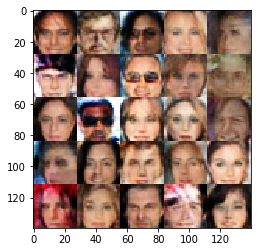

Epochs: 1/1. Discriminator Loss: 1.254 Generator Loss: 0.749
Epochs: 1/1. Discriminator Loss: 1.222 Generator Loss: 0.959


In [13]:
batch_size = 32
z_dim = 100
learning_rate = 0.0002
beta1 = 0.5


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 1

celeba_dataset = helper.Dataset('celeba', glob(os.path.join(data_dir, 'img_align_celeba/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, celeba_dataset.get_batches,
          celeba_dataset.shape, celeba_dataset.image_mode)